In [1]:
%reset 

# clears variables in workspace
# note on resetting:
# especially while you're debugging, you want to clear your variables between attempts to solve. Why?
# A) you may have noticed that pyomo doesn't like things being redefined
# more importantly, B) the variables keep their values, so an infeasible solution becomes an infeasible guess. 

# import libraries
# Pyomo stuff
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# other
import sympy as sym
import numpy as np
sym.init_printing()
from IPython.display import display #for pretty 
#plotting
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
from matplotlib.animation import PillowWriter
%matplotlib inline

# create the model
m = ConcreteModel()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Variables

In [2]:
#Node Points
N = 40
cN = 3

#Mass
FemurMass = 0.4 #kg
TibiaMass = 0.4 #kg          #CALLEN checking if scaling is the problem    
BodyMass = 1.0 #kg

#Lengths
FemurLength = 0.115 #m
TibiaLength = 0.12 #m
BodyLength = 0.36 #m
BodyWidth = 0.22 #m
LegRadius = 0.06 #m

#Servo Motor Specs
m.Tmax = 6.864655 #Nm, corresponding to a 8V input                 #CALLEN changed this back, maybe high values is wrong
m.Wmax = 8.055366 #rad/s, corresponding to a 8V input

#Time Bounds
tmax = 0.1 #s 
tmin = 0.01 #s
hm = 1 #factor

#Travel distance
m.distance =0.070# 0.07 #m
m.vel = 0.1 #m/s

pi=np.pi


## Symbolic Equations

In [3]:
# create symbolic variables

# system parameters
g = sym.symbols('g')
m_b,m_f1,m_t1,m_f2,m_t2,m_f3,m_t3,m_f4,m_t4 = sym.symbols(['m_{body}','m_{femur1}','m_{tibia1}','m_{femur2}','m_{tibia2}','m_{femur3}','m_{tibia3}','m_{femur4}','m_{tibia4}']) # mass of links 
r,w_b,l_b,l_f1,l_t1,l_f2,l_t2,l_f3,l_t3,l_f4,l_t4 = sym.symbols(['r_{leg}','w_{body}','l_{body}','l_{femur1}','l_{tibia1}','l_{femur2}','l_{tibia2}','l_{femur3}','l_{tibia3}','l_{femur4}','l_{tibia4}']) # length of links
In_bx,In_by,In_bz,In_fxy,In_txy,In_fz,In_tz = sym.symbols(['In_{bx}','In_{by}','In_{bz}','In_{femurXY}','In_{tibiaXY}','In_{femurZ}','In_{tibiaZ}'])

# generalized coordinates
x,y,z,th_by,th_bx,th_bz,th_h1,th_k1,th_h2,th_k2,th_h3,th_k3,th_h4,th_k4 = sym.symbols(['x','y','z','theta_{bodyy}','theta_{bodyx}','theta_{bodyz}','theta_{hip1}','theta_{knee1}','theta_{hip2}','theta_{knee2}','theta_{hip3}','theta_{knee3}','theta_{hip4}','theta_{knee4}']) #position
dx,dy,dz,dth_by,dth_bx,dth_bz,dth_h1,dth_k1,dth_h2,dth_k2,dth_h3,dth_k3,dth_h4,dth_k4 = sym.symbols(['\dot{x}','\dot{y}','\dot{z}','\dot{\\theta}_{bodyy}','\dot{\\theta}_{bodyx}','\dot{\\theta}_{bodyz}','\dot{\\theta}_{hip1}','\dot{\\theta}_{knee1}','\dot{\\theta}_{hip2}','\dot{\\theta}_{knee2}','\dot{\\theta}_{hip3}','\dot{\\theta}_{knee3}','\dot{\\theta}_{hip4}','\dot{\\theta}_{knee4}']) #velocity
ddx,ddy,ddz,ddth_by,ddth_bx,ddth_bz,ddth_h1,ddth_k1,ddth_h2,ddth_k2,ddth_h3,ddth_k3,ddth_h4,ddth_k4 = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{z}','\ddot{\\theta}_{bodyy}','\ddot{\\theta}_{bodyx}','\ddot{\\theta}_{bodyz}','\ddot{\\theta}_{hip1}','\ddot{\\theta}_{knee1}','\ddot{\\theta}_{hip2}','\ddot{\\theta}_{knee2}','\ddot{\\theta}_{hip3}','\ddot{\\theta}_{knee3}','\ddot{\\theta}_{hip4}','\ddot{\\theta}_{knee4}']) #acceleration

q = sym.Matrix([[x],[y],[z],[th_by],[th_bx],[th_bz],[th_h1],[th_k1],[th_h2],[th_k2],[th_h3],[th_k3],[th_h4],[th_k4]]) #group into matrices
dq = sym.Matrix([[dx],[dy],[dz],[dth_by],[dth_bx],[dth_bz],[dth_h1],[dth_k1],[dth_h2],[dth_k2],[dth_h3],[dth_k3],[dth_h4],[dth_k4]])
ddq = sym.Matrix([[ddx],[ddy],[ddz],[ddth_by],[ddth_bx],[ddth_bz],[ddth_h1],[ddth_k1],[ddth_h2],[ddth_k2],[ddth_h3],[ddth_k3],[ddth_h4],[ddth_k4]])

# forces
tau_h1,tau_k1,tau_h2,tau_k2,tau_h3,tau_k3,tau_h4,tau_k4,GRF1x,GRF1y,GRF1z,GRF2x,GRF2y,GRF2z,GRF3x,GRF3y,GRF3z,GRF4x,GRF4y,GRF4z = sym.symbols(['\\tau_{hip1}','\\tau_{knee1}','\\tau_{hip2}','\\tau_{knee2}','\\tau_{hip3}','\\tau_{knee3}','\\tau_{hip4}','\\tau_{knee4}','G1_x','G1_y','G1_z','G2_x','G2_y','G2_z','G3_x','G3_y','G3_z','G4_x','G4_y','G4_z']) 

print('Done')

Done


In [4]:
#Euler Rotation Theorem
Rx=[[1, 0, 0], [0, sym.cos(th_bx), -sym.sin(th_bx)], [0, sym.sin(th_bx), sym.cos(th_bx)]]
Ry=[[sym.cos(th_by), 0, sym.sin(th_by)], [0, 1, 0], [-sym.sin(th_by), 0, sym.cos(th_by)]]
Rz=[[sym.cos(th_bz), -sym.sin(th_bz), 0], [sym.sin(th_bz), sym.cos(th_bz), 0], [0, 0, 1]]
Rxz=np.matmul(Rx,Rz)
Rxyz=np.matmul(Rxz,Ry)

hip11=[[l_b/2],[w_b/2],[0]]
hip22=[[l_b/2],[-w_b/2],[0]]
hip33=[[-l_b/2],[w_b/2],[0]]
hip44=[[-l_b/2],[-w_b/2],[0]]

femur11=[[l_b/2+l_f1/2*sym.sin(th_h1)],[w_b/2],[-l_f1/2*sym.cos(th_h1)]]
femur22=[[l_b/2+l_f1/2*sym.sin(th_h2)],[-w_b/2],[-l_f1/2*sym.cos(th_h2)]]
femur33=[[-l_b/2+l_f1/2*sym.sin(th_h3)],[w_b/2],[-l_f1/2*sym.cos(th_h3)]]
femur44=[[-l_b/2+l_f1/2*sym.sin(th_h4)],[-w_b/2],[-l_f1/2*sym.cos(th_h4)]]

knee11=[[l_b/2+l_f1*sym.sin(th_h1)],[w_b/2],[-l_f1*sym.cos(th_h1)]]
knee22=[[l_b/2+l_f1*sym.sin(th_h2)],[-w_b/2],[-l_f1*sym.cos(th_h2)]]
knee33=[[-l_b/2+l_f1*sym.sin(th_h3)],[w_b/2],[-l_f1*sym.cos(th_h3)]]
knee44=[[-l_b/2+l_f1*sym.sin(th_h4)],[-w_b/2],[-l_f1*sym.cos(th_h4)]]


#CALLEN: note you are using l_t1 for all, and not l_t2, l_t3 etc (same for l_f). Shouldnt make a difference though


tibia11=[[l_b/2+l_f1*sym.sin(th_h1)+l_t1/2*sym.sin(th_k1)],[w_b/2],[-l_f1*sym.cos(th_h1)-l_t1/2*sym.cos(th_k1)]]
tibia22=[[l_b/2+l_f1*sym.sin(th_h2)+l_t1/2*sym.sin(th_k2)],[-w_b/2],[-l_f1*sym.cos(th_h2)-l_t1/2*sym.cos(th_k2)]]
tibia33=[[-l_b/2+l_f1*sym.sin(th_h3)+l_t1/2*sym.sin(th_k3)],[w_b/2],[-l_f1*sym.cos(th_h3)-l_t1/2*sym.cos(th_k3)]]
tibia44=[[-l_b/2+l_f1*sym.sin(th_h4)+l_t1/2*sym.sin(th_k4)],[-w_b/2],[-l_f1*sym.cos(th_h4)-l_t1/2*sym.cos(th_k4)]]

foot11=[[l_b/2+l_f1*sym.sin(th_h1)+l_t1*sym.sin(th_k1)],[w_b/2],[-l_f1*sym.cos(th_h1)-l_t1*sym.cos(th_k1)]]
foot22=[[l_b/2+l_f1*sym.sin(th_h2)+l_t1*sym.sin(th_k2)],[-w_b/2],[-l_f1*sym.cos(th_h2)-l_t1*sym.cos(th_k2)]]
foot33=[[-l_b/2+l_f1*sym.sin(th_h3)+l_t1*sym.sin(th_k3)],[w_b/2],[-l_f1*sym.cos(th_h3)-l_t1*sym.cos(th_k3)]]
foot44=[[-l_b/2+l_f1*sym.sin(th_h4)+l_t1*sym.sin(th_k4)],[-w_b/2],[-l_f1*sym.cos(th_h4)-l_t1*sym.cos(th_k4)]]

print('Done')

Done


In [5]:
# STEP 1: position vector (COM of each link) 
#using relative angles 

com_b = sym.Matrix([[x],[y],[z]])

com_h1 = sym.Matrix(com_b + np.matmul(Rxyz,hip11))
com_h2 = sym.Matrix(com_b + np.matmul(Rxyz,hip22))
com_h3 = sym.Matrix(com_b + np.matmul(Rxyz,hip33))
com_h4 = sym.Matrix(com_b + np.matmul(Rxyz,hip44))

com_f1 = sym.Matrix(com_b + np.matmul(Rxyz,femur11))
com_f2 = sym.Matrix(com_b + np.matmul(Rxyz,femur22))
com_f3 = sym.Matrix(com_b + np.matmul(Rxyz,femur33))
com_f4 = sym.Matrix(com_b + np.matmul(Rxyz,femur44))

com_k1 = sym.Matrix(com_b + np.matmul(Rxyz,knee11))
com_k2 = sym.Matrix(com_b + np.matmul(Rxyz,knee22))
com_k3 = sym.Matrix(com_b + np.matmul(Rxyz,knee33))
com_k4 = sym.Matrix(com_b + np.matmul(Rxyz,knee44))

com_t1 = sym.Matrix(com_b + np.matmul(Rxyz,tibia11))
com_t2 = sym.Matrix(com_b + np.matmul(Rxyz,tibia22))
com_t3 = sym.Matrix(com_b + np.matmul(Rxyz,tibia33))
com_t4 = sym.Matrix(com_b + np.matmul(Rxyz,tibia44))

foot1_pos= sym.Matrix(com_b + np.matmul(Rxyz,foot11))
foot1x = sym.Matrix([foot1_pos[0]])
foot1y = sym.Matrix([foot1_pos[1]])
foot1z = sym.Matrix([foot1_pos[2]])
foot1z = foot1z[0].simplify()
foot2_pos= sym.Matrix(com_b + np.matmul(Rxyz,foot22))
foot2x = sym.Matrix([foot2_pos[0]])
foot2y = sym.Matrix([foot2_pos[1]])
foot2z = sym.Matrix([foot2_pos[2]])
foot2z = foot2z[0].simplify()
foot3_pos= sym.Matrix(com_b + np.matmul(Rxyz,foot33))
foot3x = sym.Matrix([foot3_pos[0]])
foot3y = sym.Matrix([foot3_pos[1]])
foot3z = sym.Matrix([foot3_pos[2]])
foot3z = foot3z[0].simplify()
foot4_pos= sym.Matrix(com_b + np.matmul(Rxyz,foot44))
foot4x = sym.Matrix([foot4_pos[0]])
foot4y = sym.Matrix([foot4_pos[1]])
foot4z = sym.Matrix([foot4_pos[2]])
foot4z = foot4z[0].simplify()
print('Done')

Done


In [6]:
# STEP 2: generate expressions for the system space velocities
v_b = com_b.jacobian(q)*dq

v_f1 = com_f1.jacobian(q)*dq
v_t1 = com_t1.jacobian(q)*dq

v_f2 = com_f2.jacobian(q)*dq
v_t2 = com_t2.jacobian(q)*dq

v_f3 = com_f3.jacobian(q)*dq
v_t3 = com_t3.jacobian(q)*dq

v_f4 = com_f4.jacobian(q)*dq
v_t4 = com_t4.jacobian(q)*dq

foot1dx = foot1x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot1dx = foot1dx[0].simplify()
foot1dy = foot1y.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot1dy = foot1dy[0].simplify()

foot2dx = foot2x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot2dx = foot2dx[0].simplify()
foot2dy = foot2y.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot2dy = foot2dy[0].simplify()

foot3dx = foot3x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot3dx = foot3dx[0].simplify()
foot3dy = foot3y.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot3dy = foot3dy[0].simplify()

foot4dx = foot4x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot4dx = foot4dx[0].simplify()
foot4dy = foot4y.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot4dy = foot4dy[0].simplify()

print('Done')

Done


In [7]:
# STEP 3: generate expressions for the kinetic and potential energy

#Stacy Shield's method
# T = sym.Matrix([0.5*m1*(dx1**2+dy1**2) + 0.5*m2*(dx2**2+dy2**2) + 0.5*In1*dth1a**2 + 0.5*In2*dth2a**2])
# V = sym.Matrix([m1*g*y1 + m2*g*y2])

#Callen Fisher's method, better for bigger problems.
M_b = sym.Matrix([[m_b,m_b,m_b]])
M_f1 = sym.Matrix([[m_f1,m_f1,m_f1]])
M_t1 = sym.Matrix([[m_t1,m_t1,m_t1]])
M_f2 = sym.Matrix([[m_f2,m_f2,m_f2]])
M_t2 = sym.Matrix([[m_t2,m_t2,m_t2]])
M_f3 = sym.Matrix([[m_f3,m_f3,m_f3]])
M_t3 = sym.Matrix([[m_t3,m_t3,m_t3]])
M_f4 = sym.Matrix([[m_f4,m_f4,m_f4]])
M_t4 = sym.Matrix([[m_t4,m_t4,m_t4]])

I_b=sym.Matrix([[In_bx,In_by,In_bz]])
I_f=sym.Matrix([[In_fxy,In_fxy,In_fz]])
I_t=sym.Matrix([[In_txy,In_txy,In_tz]])

W_b=sym.Matrix([[dth_bx],[dth_by],[dth_bz]])   
W_h1=sym.Matrix([[dth_bx],[dth_h1+dth_by],[dth_bz]])
W_k1=sym.Matrix([[dth_bx],[dth_k1+dth_by],[dth_bz]])
W_h2=sym.Matrix([[dth_bx],[dth_h2+dth_by],[dth_bz]])
W_k2=sym.Matrix([[dth_bx],[dth_k2+dth_by],[dth_bz]])
W_h3=sym.Matrix([[dth_bx],[dth_h3+dth_by],[dth_bz]])
W_k3=sym.Matrix([[dth_bx],[dth_k3+dth_by],[dth_bz]])
W_h4=sym.Matrix([[dth_bx],[dth_h4+dth_by],[dth_bz]])
W_k4=sym.Matrix([[dth_bx],[dth_k4+dth_by],[dth_bz]])

# linear kinetic energy:
Tl = 0.5*M_b*sym.matrix_multiply_elementwise(v_b,v_b) + 0.5*M_f1*sym.matrix_multiply_elementwise(v_f1,v_f1) + 0.5*M_t1*sym.matrix_multiply_elementwise(v_t1,v_t1) + 0.5*M_f2*sym.matrix_multiply_elementwise(v_f2,v_f2) + 0.5*M_t2*sym.matrix_multiply_elementwise(v_t2,v_t2) + 0.5*M_f3*sym.matrix_multiply_elementwise(v_f3,v_f3) + 0.5*M_t3*sym.matrix_multiply_elementwise(v_t3,v_t3) + 0.5*M_f4*sym.matrix_multiply_elementwise(v_f4,v_f4) + 0.5*M_t4*sym.matrix_multiply_elementwise(v_t4,v_t4)
# angular kinetic energy:
Tw =  0.5*I_b*sym.matrix_multiply_elementwise(W_b,W_b) + 0.5*I_f*sym.matrix_multiply_elementwise(W_h1,W_h1) + 0.5*I_t*sym.matrix_multiply_elementwise(W_k1,W_k1) + 0.5*I_f*sym.matrix_multiply_elementwise(W_h2,W_h2) + 0.5*I_t*sym.matrix_multiply_elementwise(W_k2,W_k2) + 0.5*I_f*sym.matrix_multiply_elementwise(W_h3,W_h3) + 0.5*I_t*sym.matrix_multiply_elementwise(W_k3,W_k3) + 0.5*I_f*sym.matrix_multiply_elementwise(W_h4,W_h4) + 0.5*I_t*sym.matrix_multiply_elementwise(W_k4,W_k4)
#this should be a 3*3 matrix of MOI and a vector of angular vel... w'*MOI*w

T = sym.Matrix([Tl[0]])+sym.Matrix([Tw[0]])
# potential energy
V = m_b*g*com_b[2] + m_f1*g*com_f1[2] + m_t1*g*com_t1[2] + m_f2*g*com_f2[2] + m_t2*g*com_t2[2] + m_f3*g*com_f3[2] + m_t3*g*com_t3[2] + m_f4*g*com_f4[2] + m_t4*g*com_t4[2]   
print('Done')

Done


In [8]:
#Use the manipulator equation to calculate the EoM
#EOM=Mddq+Cdq+G-Q-J.'*GRF ---> Callen's method

M=T.jacobian(dq)
M=M.transpose()
M=M.jacobian(dq)              

#C  = sym.zeros(len(q),len(q))  
#for i in range(len(q)):                                             
#    for j in range(len(q)):
#        for n in range(len(q)):
#            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n];

G  = sym.zeros(len(q),1)  
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);  
 
 
Q = sym.zeros(len(q),1)
Q[0]=0                 #x
Q[1]=0                 #y
Q[2]=0                 #z
Q[3]=0    #th x
Q[4]=-tau_h1-tau_h2-tau_h3-tau_h4-tau_k1-tau_k2-tau_k3-tau_k4                           #th y
Q[5]=0                          #th z
Q[6]=tau_h1              #th hip 1
Q[7]=tau_k1                     #th knee 1
Q[8]=tau_h2              #th hip 2
Q[9]=tau_k2                     #th knee 2
Q[10]=tau_h3              #th hip 3
Q[11]=tau_k3                     #th knee 3
Q[12]=tau_h4              #th hip 4
Q[13]=tau_k4                    #th knee 4

J1=foot1_pos.jacobian(q)
GRF_1 = J1.transpose()*sym.Matrix([[GRF1x],[GRF1y],[GRF1z]]) 

J2=foot2_pos.jacobian(q)
GRF_2 = J2.transpose()*sym.Matrix([[GRF2x],[GRF2y],[GRF2z]])

J3=foot3_pos.jacobian(q)
GRF_3 = J3.transpose()*sym.Matrix([[GRF3x],[GRF3y],[GRF3z]]) 

J4=foot4_pos.jacobian(q)
GRF_4 = J4.transpose()*sym.Matrix([[GRF4x],[GRF4y],[GRF4z]])

EOM=M*ddq+G-Q-GRF_1-GRF_2-GRF_3-GRF_4#C*dq+


#CALLEN REmoved C matrix




EOMs = sym.zeros(len(q),1)
EOMcounter = 0
print(f"EOM simplification starts")
for j in range(len(q)):
    EOMs[j] = EOM[j]#.simplify()  #--> Helps to make simulation faster for bigger problems
#     print(f"EOM loop counter: {j}")
    EOMcounter = EOMcounter + 1
    
    

print('Done')

EOM simplification starts
Done


## Pyomo Stuff Starts

In [9]:
# Lambdify

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,m_b,m_f1,m_t1,m_f2,m_t2,m_f3,m_t3,m_f4,m_t4,
            l_b,l_f1,l_t1,l_f2,l_t2,l_f3,l_t3,l_f4,l_t4,w_b,r,
            In_bx,In_by,In_bz,In_fxy,In_txy,In_fz,In_tz,
            x,y,z,th_bx,th_by,th_bz,th_h1,th_k1,th_h2,th_k2,th_h3,th_k3,th_h4,th_k4,
            dx,dy,dz,dth_bx,dth_by,dth_bz,dth_h1,dth_k1,dth_h2,dth_k2,dth_h3,dth_k3,dth_h4,dth_k4,
            ddx,ddy,ddz,ddth_bx,ddth_by,ddth_bz,ddth_h1,ddth_k1,ddth_h2,ddth_k2,ddth_h3,ddth_k3,ddth_h4,ddth_k4,
            tau_h1,tau_k1,tau_h2,tau_k2,tau_h3,tau_k3,tau_h4,tau_k4,
            GRF1x,GRF1y,GRF1z,GRF2x,GRF2y,GRF2z,GRF3x,GRF3y,GRF3z,GRF4x,GRF4y,GRF4z]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_z = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_th_bx = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_th_by = sym.lambdify(sym_list,EOMs[4],modules = [func_map])
lambEOM_th_bz = sym.lambdify(sym_list,EOMs[5],modules = [func_map])
lambEOM_th_h1 = sym.lambdify(sym_list,EOMs[6],modules = [func_map])
lambEOM_th_k1 = sym.lambdify(sym_list,EOMs[7],modules = [func_map])
lambEOM_th_h2 = sym.lambdify(sym_list,EOMs[8],modules = [func_map])
lambEOM_th_k2 = sym.lambdify(sym_list,EOMs[9],modules = [func_map])
lambEOM_th_h3 = sym.lambdify(sym_list,EOMs[10],modules = [func_map])
lambEOM_th_k3 = sym.lambdify(sym_list,EOMs[11],modules = [func_map])
lambEOM_th_h4 = sym.lambdify(sym_list,EOMs[12],modules = [func_map])
lambEOM_th_k4 = sym.lambdify(sym_list,EOMs[13],modules = [func_map])

lamb_foot1z = sym.lambdify(sym_list,foot1z,modules = [func_map])
lamb_foot1dx = sym.lambdify(sym_list,foot1dx,modules = [func_map])
lamb_foot1dy = sym.lambdify(sym_list,foot1dy,modules = [func_map])

lamb_foot2z = sym.lambdify(sym_list,foot2z,modules = [func_map])
lamb_foot2dx = sym.lambdify(sym_list,foot2dx,modules = [func_map])
lamb_foot2dy = sym.lambdify(sym_list,foot2dy,modules = [func_map])

lamb_foot3z = sym.lambdify(sym_list,foot3z,modules = [func_map])
lamb_foot3dx = sym.lambdify(sym_list,foot3dx,modules = [func_map])
lamb_foot3dy = sym.lambdify(sym_list,foot3dy,modules = [func_map])

lamb_foot4z = sym.lambdify(sym_list,foot4z,modules = [func_map])
lamb_foot4dx = sym.lambdify(sym_list,foot4dx,modules = [func_map])
lamb_foot4dy = sym.lambdify(sym_list,foot4dy,modules = [func_map])

print('Done')

Done


In [10]:
# ConcreteModel SETS -------------------------------------------------------------------------------
m.N = RangeSet(N)
m.cN = RangeSet(cN)

# sets can have multidimensional indices
# (probably a little gratuitous for such a simple model, but thought I'd show you anyway)
links = [('body',1),('bodyWidth',1),('legRadius',1),('femur',1),('tibia',1),('femur',2),('tibia',2),('femur',3),('tibia',3),('femur',4),('tibia',4)]
m.L = Set(dimen=2, initialize = links)

DOFs = ['x','y','z','theta_bx','theta_by','theta_bz','theta_h1','theta_k1','theta_h2','theta_k2','theta_h3','theta_k3','theta_h4','theta_k4']
m.DOF = Set(initialize = DOFs) # the coordinates for each link

# system coordinates
m.q = Var(m.N, m.cN, m.DOF) # position
m.dq = Var(m.N, m.cN, m.DOF) # velocity
m.ddq = Var(m.N, m.cN, m.DOF) # acceleration

m.q0 = Var(m.N, m.DOF) # position
m.dq0 = Var(m.N, m.DOF) # velocity

m.tt = Var(m.N, m.cN)
m.tt0 = Var(m.N, bounds = (0,10))

m.h = Var(m.N, bounds =(tmin,tmax))

a = [[0.19681547722366, 0.39442431473909, 0.37640306270047],
     [-0.06553542585020, 0.29207341166523, 0.51248582618842],
     [0.02377097434822, -0.04154875212600, 0.11111111111111]]
print('Done')

Done


In [11]:
# Substituting variables into ConcreteModel-----------------------------------------------------------------------------------------
m.g = Param(initialize = 9.81) 

# mass of links
def get_m(n, lb, ln):
    if lb == 'femur':
        return FemurMass
    elif lb == 'body':
        return BodyMass
    else: return TibiaMass
m.m = Param(m.L, initialize = get_m)

mbody = sum(m.m[l] for l in links)
mBW = mbody*m.g.value
# m.m.pprint()
print(f'total body mass: {mbody}')
print(f'total body weight: {mBW}')

# length of links
def get_len(n, lb, ln):
    if lb == 'femur':
        return FemurLength
    elif lb == 'body':
        return BodyLength
    elif lb == 'bodyWidth':
        return BodyWidth
    elif lb == 'legRadius':
        return LegRadius
    else: return TibiaLength
m.l = Param(m.L, initialize = get_len) 
# m.l.pprint()

#Inertia
def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function. Yes, it is dumb.
    return m.m[l]*m.l[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

#Body inertia
m.inbx = 1/12*m.m[('body',1)]*m.l[('body',1)]**2
m.inby = 1/12*m.m[('body',1)]*m.l[('bodyWidth',1)]**2
m.inbz = 1/12*m.m[('body',1)]*(m.l[('body',1)]**2+m.l[('bodyWidth',1)]**2)
m.infxy = m.m[('femur',1)]*m.l[('femur',1)]**2/12
m.intxy = m.m[('tibia',1)]*m.l[('tibia',1)]**2/12
m.infz = m.m[('femur',1)]*m.l[('legRadius',1)]**2/2
m.intz = m.m[('tibia',1)]*m.l[('legRadius',1)]**2/2
    
    
    #CALLEN: maybe print out the inertia values and see if they are reasonable values
    
    
print("Done")

total body mass: 5.0
total body weight: 49.050000000000004
Done


In [12]:
def ContConstraint_p (m, n, dof):
    if n > 1:
        return m.q0[n,dof] == m.q[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_p = Constraint(m.N, m.DOF, rule = ContConstraint_p)

def ContConstraint_v (m, n, dof):
    if n > 1:
        return m.dq0[n,dof] == m.dq[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_v = Constraint(m.N, m.DOF, rule = ContConstraint_v)

def ContConstraint_tt (m, n):
    if n > 1:
        return m.tt0[n] == m.tt[n-1,3]
    else:
        return Constraint.Skip
m.ContConstraint_tt = Constraint(m.N, rule = ContConstraint_tt)

print('Done')

Done


In [13]:
def integrate_p(m, n, c, dof): # for positions
    if n > 0:
        return m.q[n,c,dof] == m.q0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.dq[n,1,dof] \
                                                         +a[1][c-1]*m.dq[n,2,dof] \
                                                         +a[2][c-1]*m.dq[n,3,dof])
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.cN, m.DOF, rule = integrate_p)

def integrate_v(m,n,c,dof): # for velocities
    if n > 0:
        return m.dq[n,c,dof] == m.dq0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.ddq[n,1,dof] \
                                                           +a[1][c-1]*m.ddq[n,2,dof] \
                                                           +a[2][c-1]*m.ddq[n,3,dof])
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.cN, m.DOF, rule = integrate_v)

def integrate_tt(m,n,c): # for time 
    if n > 0:
        return m.tt[n,c] == m.tt0[n] + hm*m.h[n]*(a[0][c-1]+a[1][c-1]+a[2][c-1])
    else:
        return Constraint.Skip 
m.integrate_tt = Constraint(m.N, m.cN, rule = integrate_tt)

print('Done')

Done


In [14]:
signs = ['ps', 'ng']
m.sgn = Set(initialize = ['ps', 'ng'])
WDOFs = ['X','Y','Z','THETAbx','THETAby','THETAbz', 'THETAh1','THETAk1', 'THETAh2','THETAk2', 'THETAh3','THETAk3','THETAh4','THETAk4']
m.WDOF = Set(initialize=WDOFs) #change the coordinates

#CALLEN: double check the values below, I increased to 600 to give the optimizer some more wiggle room to find a sol 

m.GRF1 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,600)) # should bound it to 10*mBW
m.GRF2 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,600)) # should bound it to 10*m_robot*g
m.GRF3 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,600)) # should bound it to 10*m_robot*g
m.GRF4 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,600)) # should bound it to 10*m_robot*g
m.eps = Param(initialize=1000.0, mutable=True)
m.mu = Param(initialize =1.00)
print('Done')

Done


In [15]:
# SLACK VARIABLES
#CALLEN hopefully a bunch of these will not be required 


m.a_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_1x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_1x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_1x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_1x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_1y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_1y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_1y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_1y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_1      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_2x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_2x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_2x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_2x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_2y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_2y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_2y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_2y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_2      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_3  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_3  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_3 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_3 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_3x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_3x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_3x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_3x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_3y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_3y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_3y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_3y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_3      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_4  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_4  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_4 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_4 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_4x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_4x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_4x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_4x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_4y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_4y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_4y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_4y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_4      = Var(m.N, m.cN, bounds = (0.0,None)) 

print('Done')

Done


In [16]:
# # CONTACTS
# # Leg 1 --------------------------------------------------------------------------------------------------------------

# #CALLEN allows foot to make and break contact 
def def_a_contact_1(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_1[n,c] == lamb_foot1z(*var_list)
m.def_a_contact_1 = Constraint(m.N, m.cN, rule = def_a_contact_1)

def def_b_contact_1(m,n,c):   
    return m.b_contact_1[n,c] == m.GRF1[n,c,'Z','ps']
m.def_b_contact_1 = Constraint(m.N, m.cN, rule = def_b_contact_1)

#condition
def def_contact_1_pr(m,n):
    a_contact_1_pr = m.a_contact_1[n,1] + m.a_contact_1[n,2] + m.a_contact_1[n,3] 
    b_contact_1_pr = m.b_contact_1[n,1] + m.b_contact_1[n,2] + m.b_contact_1[n,3]  
    return a_contact_1_pr*b_contact_1_pr <= m.eps
m.def_contact_1_pr = Constraint(m.N, rule = def_contact_1_pr)

# Leg 2 --------------------------------------------------------------------------------------------------------------
def def_a_contact_2(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_2[n,c] == lamb_foot2z(*var_list)
m.def_a_contact_2 = Constraint(m.N, m.cN, rule = def_a_contact_2)

def def_b_contact_2(m,n,c):   
    return m.b_contact_2[n,c] == m.GRF2[n,c,'Z','ps']
m.def_b_contact_2 = Constraint(m.N, m.cN, rule = def_b_contact_2)

#condition
def def_contact_2_pr(m,n):
    a_contact_2_pr = m.a_contact_2[n,1] + m.a_contact_2[n,2] + m.a_contact_2[n,3] 
    b_contact_2_pr = m.b_contact_2[n,1] + m.b_contact_2[n,2] + m.b_contact_2[n,3]  
    return a_contact_2_pr*b_contact_2_pr <= m.eps
m.def_contact_2_pr = Constraint(m.N, rule = def_contact_2_pr)

# Leg 3 --------------------------------------------------------------------------------------------------------------
def def_a_contact_3(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_3[n,c] == lamb_foot3z(*var_list)
m.def_a_contact_3 = Constraint(m.N, m.cN, rule = def_a_contact_3)

def def_b_contact_3(m,n,c):   
    return m.b_contact_3[n,c] == m.GRF3[n,c,'Z','ps']
m.def_b_contact_3 = Constraint(m.N, m.cN, rule = def_b_contact_3)

#condition
def def_contact_3_pr(m,n):
    a_contact_3_pr = m.a_contact_3[n,1] + m.a_contact_3[n,2] + m.a_contact_3[n,3] 
    b_contact_3_pr = m.b_contact_3[n,1] + m.b_contact_3[n,2] + m.b_contact_3[n,3]  
    return a_contact_3_pr*b_contact_3_pr <= m.eps
m.def_contact_3_pr = Constraint(m.N, rule = def_contact_3_pr)

# Leg 4 --------------------------------------------------------------------------------------------------------------
def def_a_contact_4(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_4[n,c] == lamb_foot4z(*var_list)
m.def_a_contact_4 = Constraint(m.N, m.cN, rule = def_a_contact_4)

def def_b_contact_4(m,n,c):   
    return m.b_contact_4[n,c] == m.GRF4[n,c,'Z','ps']
m.def_b_contact_4 = Constraint(m.N, m.cN, rule = def_b_contact_4)

#condition
def def_contact_4_pr(m,n):
    a_contact_4_pr = m.a_contact_4[n,1] + m.a_contact_4[n,2] + m.a_contact_4[n,3] 
    b_contact_4_pr = m.b_contact_4[n,1] + m.b_contact_4[n,2] + m.b_contact_4[n,3]  
    return a_contact_4_pr*b_contact_4_pr <= m.eps
m.def_contact_4_pr = Constraint(m.N, rule = def_contact_4_pr)

print('Done')

Done


In [17]:
# FRICTION CONE
# Leg 1 -------------------------------------------------------------------------------------------------------------
def def_a_friction_1(m,n,c):   
    return (m.mu*m.GRF1[n,c,'Z','ps'])**2 >= ((m.GRF1[n,c,'X','ps'] + m.GRF1[n,c,'X','ng'])**2+(m.GRF1[n,c,'Y','ps'] + m.GRF1[n,c,'Y','ng'])**2)
m.def_a_friction_1 = Constraint(m.N, m.cN, rule = def_a_friction_1)

# Leg 2 --------------------------------------------------------------------------------------------------------------
def def_a_friction_2(m,n,c):   
    return  (m.mu*m.GRF2[n,c,'Z','ps'])**2 >= ((m.GRF2[n,c,'X','ps'] + m.GRF2[n,c,'X','ng'])**2+(m.GRF2[n,c,'Y','ps'] + m.GRF2[n,c,'Y','ng'])**2)
m.def_a_friction_2 = Constraint(m.N, m.cN, rule = def_a_friction_2)

# Leg 3 --------------------------------------------------------------------------------------------------------------
def def_a_friction_3(m,n,c):   
    return (m.mu*m.GRF3[n,c,'Z','ps'])**2 >= ((m.GRF3[n,c,'X','ps'] + m.GRF3[n,c,'X','ng'])**2+(m.GRF3[n,c,'Y','ps'] + m.GRF3[n,c,'Y','ng'])**2)
m.def_a_friction_3 = Constraint(m.N, m.cN, rule = def_a_friction_3)

# Leg 4 --------------------------------------------------------------------------------------------------------------
def def_a_friction_4(m,n,c):   
    return (m.mu*m.GRF4[n,c,'Z','ps'])**2 >= ((m.GRF4[n,c,'X','ps'] + m.GRF4[n,c,'X','ng'])**2+(m.GRF4[n,c,'Y','ps'] + m.GRF4[n,c,'Y','ng'])**2)
m.def_a_friction_4 = Constraint(m.N, m.cN, rule = def_a_friction_4)


print('Done')

Done


In [18]:
def def_F1_x(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF1[n,c,'Z','ps']*lamb_foot1dx(*var_list)*lamb_foot1dx(*var_list)<= m.eps/1
m.def_F1_x = Constraint(m.N, m.cN, rule = def_F1_x)
def def_F1_y(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF1[n,c,'Z','ps']*lamb_foot1dy(*var_list)*lamb_foot1dy(*var_list)<= m.eps/1
m.def_F1_y = Constraint(m.N, m.cN, rule = def_F1_y)






def def_F2_x(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF2[n,c,'Z','ps']*lamb_foot2dx(*var_list)*lamb_foot2dx(*var_list)<= m.eps/1
m.def_F2_x = Constraint(m.N, m.cN, rule = def_F2_x)
def def_F2_y(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF2[n,c,'Z','ps']*lamb_foot2dy(*var_list)*lamb_foot2dy(*var_list)<= m.eps/1
m.def_F2_y = Constraint(m.N, m.cN, rule = def_F2_y)





def def_F3_x(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF3[n,c,'Z','ps']*lamb_foot3dx(*var_list)*lamb_foot3dx(*var_list)<= m.eps/1
m.def_F3_x = Constraint(m.N, m.cN, rule = def_F3_x)
def def_F3_y(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF3[n,c,'Z','ps']*lamb_foot3dy(*var_list)*lamb_foot3dy(*var_list)<= m.eps/1
m.def_F3_y = Constraint(m.N, m.cN, rule = def_F3_y)



def def_F4_x(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF4[n,c,'Z','ps']*lamb_foot4dx(*var_list)*lamb_foot4dx(*var_list)<= m.eps/1
m.def_F4_x = Constraint(m.N, m.cN, rule = def_F4_x)
def def_F4_y(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF4[n,c,'Z','ps']*lamb_foot4dy(*var_list)*lamb_foot4dy(*var_list)<= m.eps/1
m.def_F4_y = Constraint(m.N, m.cN, rule = def_F4_y)

print('Done')

Done


In [19]:
m.tau_h1 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_1
m.tau_k1 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_1
m.tau_h2 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_2
m.tau_k2 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_2
m.tau_h3 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_3
m.tau_k3 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_3
m.tau_h4 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_4
m.tau_k4 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_4

# Leg 1 --------------------------------------------------------------------------------------------------------------
def def_hip1_motor_model_p(m,n):
    return  m.tau_h1[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h1']-m.dq0[n,'theta_by'])
m.def_hip1_motor_model_p = Constraint(m.N, rule = def_hip1_motor_model_p)
def def_hip1_motor_model_n(m,n):
    return  m.tau_h1[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h1']-m.dq0[n,'theta_by'])
m.def_hip1_motor_model_n = Constraint(m.N, rule = def_hip1_motor_model_n)

def def_knee1_motor_model_p(m,n):
    return  m.tau_k1[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k1']-m.dq0[n,'theta_h1'])
m.def_knee1_motor_model_p = Constraint(m.N, rule = def_knee1_motor_model_p)
def def_knee1_motor_model_n(m,n):
    return  m.tau_k1[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k1']-m.dq0[n,'theta_h1'])
m.def_knee1_motor_model_n = Constraint(m.N, rule = def_knee1_motor_model_n)

# Leg 2 --------------------------------------------------------------------------------------------------------------
def def_hip2_motor_model_p(m,n):
    return  m.tau_h2[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h2']-m.dq0[n,'theta_by'])
m.def_hip2_motor_model_p = Constraint(m.N, rule = def_hip2_motor_model_p)
def def_hip2_motor_model_n(m,n):
    return  m.tau_h2[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h2']-m.dq0[n,'theta_by'])
m.def_hip2_motor_model_n = Constraint(m.N, rule = def_hip2_motor_model_n)

def def_knee2_motor_model_p(m,n):
    return  m.tau_k2[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k2']-m.dq0[n,'theta_h2'])
m.def_knee2_motor_model_p = Constraint(m.N, rule = def_knee2_motor_model_p)
def def_knee2_motor_model_n(m,n):
    return  m.tau_k2[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k2']-m.dq0[n,'theta_h2'])
m.def_knee2_motor_model_n = Constraint(m.N, rule = def_knee2_motor_model_n)

# Leg 3 --------------------------------------------------------------------------------------------------------------
def def_hip3_motor_model_p(m,n):
    return  m.tau_h3[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h3']-m.dq0[n,'theta_by'])
m.def_hip3_motor_model_p = Constraint(m.N, rule = def_hip3_motor_model_p)
def def_hip3_motor_model_n(m,n):
    return  m.tau_h3[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h3']-m.dq0[n,'theta_by'])
m.def_hip3_motor_model_n = Constraint(m.N, rule = def_hip3_motor_model_n)

def def_knee3_motor_model_p(m,n):
    return  m.tau_k3[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k3']-m.dq0[n,'theta_h3'])
m.def_knee3_motor_model_p = Constraint(m.N, rule = def_knee3_motor_model_p)
def def_knee3_motor_model_n(m,n):
    return  m.tau_k3[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k3']-m.dq0[n,'theta_h3'])
m.def_knee3_motor_model_n = Constraint(m.N, rule = def_knee3_motor_model_n)

# Leg 4 --------------------------------------------------------------------------------------------------------------
def def_hip4_motor_model_p(m,n):
    return  m.tau_h4[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h4']-m.dq0[n,'theta_by'])
m.def_hip4_motor_model_p = Constraint(m.N, rule = def_hip4_motor_model_p)
def def_hip4_motor_model_n(m,n):
    return  m.tau_h4[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h4']-m.dq0[n,'theta_by'])
m.def_hip4_motor_model_n = Constraint(m.N, rule = def_hip4_motor_model_n)

def def_knee4_motor_model_p(m,n):
    return  m.tau_k4[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k4']-m.dq0[n,'theta_h4'])
m.def_knee4_motor_model_p = Constraint(m.N, rule = def_knee4_motor_model_p)
def def_knee4_motor_model_n(m,n):
    return  m.tau_k4[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k4']-m.dq0[n,'theta_h4'])
m.def_knee4_motor_model_n = Constraint(m.N, rule = def_knee4_motor_model_n)

print('Done')

Done


In [20]:

#CALLEN: simplified the substitution for the below functions, trying to speed up the optimizer 


def EOM_x(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, m.cN, rule = EOM_x)

def EOM_y(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, m.cN, rule = EOM_y)

def EOM_z(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_z(*var_list) == 0
m.EOM_z = Constraint(m.N, m.cN, rule = EOM_z)

def EOM_th_bx(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_bx(*var_list) == 0
m.EOM_th_bx = Constraint(m.N, m.cN, rule = EOM_th_bx)

def EOM_th_by(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_by(*var_list) == 0
m.EOM_th_by = Constraint(m.N, m.cN, rule = EOM_th_by)

def EOM_th_bz(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_bz(*var_list) == 0
m.EOM_th_bz = Constraint(m.N, m.cN, rule = EOM_th_bz)

def EOM_th_h1(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_h1(*var_list) == 0
m.EOM_th_h1 = Constraint(m.N, m.cN, rule = EOM_th_h1)

def EOM_th_k1(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_k1(*var_list) == 0
m.EOM_th_k1 = Constraint(m.N, m.cN, rule = EOM_th_k1)

def EOM_th_h2(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_h2(*var_list) == 0
m.EOM_th_h2 = Constraint(m.N, m.cN, rule = EOM_th_h2)

def EOM_th_k2(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_k2(*var_list) == 0
m.EOM_th_k2 = Constraint(m.N, m.cN, rule = EOM_th_k2)

def EOM_th_h3(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_h3(*var_list) == 0
m.EOM_th_h3 = Constraint(m.N, m.cN, rule = EOM_th_h3)

def EOM_th_k3(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_k3(*var_list) == 0
m.EOM_th_k3 = Constraint(m.N, m.cN, rule = EOM_th_k3)

def EOM_th_h4(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_h4(*var_list) == 0
m.EOM_th_h4 = Constraint(m.N, m.cN, rule = EOM_th_h4)

def EOM_th_k4(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_k4(*var_list) == 0
m.EOM_th_k4 = Constraint(m.N, m.cN, rule = EOM_th_k4)

print('Done')

Done


In [21]:
def setxBounds(m,n):
    return (-1.0, m.q0[n,'x'], m.distance+1)
m.setxBounds = Constraint(m.N, rule=setxBounds)
def setyBounds(m,n): 
    return (-1.0, m.q0[n,'y'], 1.0)    #CALLEN changed
m.setyBounds = Constraint(m.N, rule=setyBounds)
def setzBounds(m,n):
    return (0, m.q0[n,'z'], 5)    #CALLEN changed
m.setzBounds = Constraint(m.N, rule=setzBounds)
def setth_bx_Bounds(m,n):
    return (-0.785, m.q0[n,'theta_bx'], 0.785)
m.setth_bx_Bounds = Constraint(m.N, rule=setth_bx_Bounds)
def setth_by_Bounds(m,n):
    return (-0.785, m.q0[n,'theta_by'], 0.785)
m.setth_by_Bounds = Constraint(m.N, rule=setth_by_Bounds)
def setth_bz_Bounds(m,n):
    return (-0.785, m.q0[n,'theta_bz'], 0.785)
m.setth_bz_Bounds = Constraint(m.N, rule=setth_bz_Bounds)




    #CALLEN changed-> made them larger to give wiggle room, they were +-1, but change them to the correct values
def setth_h1_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h1'],1.5)
m.setth_h1_Bounds = Constraint(m.N, rule=setth_h1_Bounds)
def setth_k1_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_k1'], 1.5)
m.setth_k1_Bounds = Constraint(m.N, rule=setth_k1_Bounds)
def setth_h2_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h2'],1.5)
m.setth_h2_Bounds = Constraint(m.N, rule=setth_h2_Bounds)
def setth_k2_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_k2'],1.5)
m.setth_k2_Bounds = Constraint(m.N, rule=setth_k2_Bounds)
def setth_h3_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h3'], 1.5)
m.setth_h3_Bounds = Constraint(m.N, rule=setth_h3_Bounds)
def setth_k3_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_k3'], 1.5)
m.setth_k3_Bounds = Constraint(m.N, rule=setth_k3_Bounds)
def setth_h4_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h4'], 1.5)
m.setth_h4_Bounds = Constraint(m.N, rule=setth_h4_Bounds)
def setth_k4_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_k4'], 1.5)
m.setth_k4_Bounds = Constraint(m.N, rule=setth_k4_Bounds)

def setdxBounds(m,n):
    return (-10, m.dq0[n,'x'],10.0)    #CALLEN changed
m.setdxBounds = Constraint(m.N, rule=setdxBounds)
def setdyBounds(m,n):
    return (-10, m.dq0[n,'y'],10)
m.setdyBounds = Constraint(m.N, rule=setdyBounds)
def setdzBounds(m,n):
    return (-10, m.dq0[n,'z'],10)
m.setdzBounds = Constraint(m.N, rule=setdzBounds)
def setdth_bx_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_bx'],4*m.Wmax)
m.setdth_bx_Bounds = Constraint(m.N, rule=setdth_bx_Bounds)
def setdth_by_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_by'],4*m.Wmax)
m.setdth_by_Bounds = Constraint(m.N, rule=setdth_by_Bounds)
def setdth_bz_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_bz'],4*m.Wmax)
m.setdth_bz_Bounds = Constraint(m.N, rule=setdth_bz_Bounds)
def setdth_h1_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_h1'],4*m.Wmax)
m.setdth_h1_Bounds = Constraint(m.N, rule=setdth_h1_Bounds)
def setdth_k1_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_k1'], 4*m.Wmax)
m.setdth_k1_Bounds = Constraint(m.N, rule=setdth_k1_Bounds)
def setdth_h2_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_h2'],4*m.Wmax)
m.setdth_h2_Bounds = Constraint(m.N, rule=setdth_h2_Bounds)
def setdth_k2_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_k2'], 4*m.Wmax)
m.setdth_k2_Bounds = Constraint(m.N, rule=setdth_k2_Bounds)
def setdth_h3_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_h3'],4*m.Wmax)
m.setdth_h3_Bounds = Constraint(m.N, rule=setdth_h3_Bounds)
def setdth_k3_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_k3'], 4*m.Wmax)
m.setdth_k3_Bounds = Constraint(m.N, rule=setdth_k3_Bounds)
def setdth_h4_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_h4'],4*m.Wmax)
m.setdth_h4_Bounds = Constraint(m.N, rule=setdth_h4_Bounds)
def setdth_k4_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_k4'], 4*m.Wmax)
m.setdth_k4_Bounds = Constraint(m.N, rule=setdth_k4_Bounds)

print('Done')

Done


In [22]:
#Relative Knee Angle Constraints
#Knee 1
def relative_th_k1a(m,n):
    return m.q0[n,'theta_k1']-m.q0[n,'theta_h1'] >= 0.1
m.relative_th_k1a = Constraint(m.N, rule = relative_th_k1a)

def th_h1_constraint(m,n):
    return m.q0[n,'theta_h1'] >= -30/180*pi
m.th_h1_constraint = Constraint(m.N, rule = th_h1_constraint)

#Knee 2
def relative_th_k2a(m,n):
    return m.q0[n,'theta_k2']-m.q0[n,'theta_h2'] >= 0.1 
m.relative_th_k2a = Constraint(m.N, rule = relative_th_k2a)

def th_h2_constraint(m,n):
    return m.q0[n,'theta_h2'] >= -30/180*pi
m.th_h2_constraint = Constraint(m.N, rule = th_h2_constraint)

#Knee 3
def relative_th_k3a(m,n):
    return m.q0[n,'theta_k3']-m.q0[n,'theta_h3'] <= -0.1
m.relative_th_k3a = Constraint(m.N, rule = relative_th_k3a)

def th_h3_constraint(m,n):
    return m.q0[n,'theta_h3'] <= 30/180*pi
m.th_h3_constraint = Constraint(m.N, rule = th_h3_constraint)

#Knee 4
def relative_th_k4a(m,n):
    return m.q0[n,'theta_k4']-m.q0[n,'theta_h4'] <= -0.1
m.relative_th_k4a = Constraint(m.N, rule = relative_th_k4a)

def th_h4_constraint(m,n):
    return m.q0[n,'theta_h4'] <= 30/180*pi
m.th_h4_constraint = Constraint(m.N, rule = th_h4_constraint)

print('Done')

Done


In [23]:
R = 1.0
D = 5.0

Domain = np.linspace(0,D,N)
Range = np.linspace(0,R,N)
for n in range(1,N+1):
    for c in range (1, cN+1): 
        #Randomizing Q Matrix
        m.q[n,c,'x'].value = 0.01   
        m.q[n,c,'y'].value = 0.01         
        m.q[n,c,'z'].value  = 0.01
        m.q[n,c,'theta_bx'].value = 0.01#np.random.uniform(np.pi/4,3*np.pi/4)  
        m.q[n,c,'theta_by'].value = 0.01#np.random.uniform(np.pi/4,3*np.pi/4)  
        m.q[n,c,'theta_bz'].value = 0.01#np.random.uniform(np.pi/4,3*np.pi/4)  
        m.q[n,c,'theta_h1'].value  = 0.01#np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k1'].value  = 0.01#np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_h2'].value  = 0.01#np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k2'].value  = 0.01#np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_h3'].value  = 0.01#np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k3'].value  = 0.01#np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_h4'].value  = 0.01#np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k4'].value  = 0.01#np.random.uniform(-np.pi/2,np.pi/2)
        
        #Setting everything else to 0.01
        for dof in DOFs:
            m.dq[n,c , dof].value = 0.01
            m.ddq[n,c , dof].value = 0.01
            
        m.GRF1[n,c,'Z','ps'].value = 0.01
        m.GRF1[n,c,'X','ps'].value = 0.01 
        m.GRF1[n,c,'X','ng'].value = 0.01 
        
        m.GRF2[n,c,'Z','ps'].value = 0.01
        m.GRF2[n,c,'X','ps'].value = 0.01 
        m.GRF2[n,c,'X','ng'].value = 0.01 
        
        m.GRF3[n,c,'Z','ps'].value = 0.01
        m.GRF3[n,c,'X','ps'].value = 0.01 
        m.GRF3[n,c,'X','ng'].value = 0.01 
        
        m.GRF4[n,c,'Z','ps'].value = 0.01
        m.GRF4[n,c,'X','ps'].value = 0.01 
        m.GRF4[n,c,'X','ng'].value = 0.01
        
print('Done')

Done


In [24]:
# #---------WALKING GAIT MOVING ONE LEG AT A TIME-----------
# #For 40 NODES
# #Enforce contact order 

# #Leg 1
# def contact_order_1(m,n,c):
#     if (n>10):
#         return m.GRF1[n,c,'Z','ps'] >=5
#         #return lamb_foot1z(*var_list)==0  #Forces foot to ground    
#     if (n<10):
#         return m.GRF1[n,c,'Z','ps'] == 0  #Forces foot to lift up
#     else:
#         return Constraint.Skip
# m.contact_order_1 = Constraint(m.N,m.cN,rule=contact_order_1)

# #Leg 2
# def contact_order_2(m,n,c):
#     if(n<20 or n>30):
#         return m.GRF2[n,c,'Z','ps'] >=5
#         #return lamb_foot2z(*var_list)==0  #Forces foot to ground 
#     if(n>20 and n<30):
#         return m.GRF2[n,c,'Z','ps'] == 0 
#     else:
#         return Constraint.Skip
# m.contact_order_2 = Constraint(m.N,m.cN,rule=contact_order_2)

# #Leg 3
# def contact_order_3(m,n,c):
#     if(n<30):
#         return m.GRF3[n,c,'Z','ps'] >= 5
#         #return lamb_foot3z(*var_list)==0  #Forces foot to ground 
#     if(n>30):
#         return m.GRF3[n,c,'Z','ps'] == 0 
#     else:
#         return Constraint.Skip
# m.contact_order_3 = Constraint(m.N,m.cN,rule=contact_order_3)
    
# #Leg 4
# def contact_order_4(m,n,c):
#     if (n<10 or n>20):
#         return m.GRF4[n,c,'Z','ps'] >= 5
#         #return lamb_foot4z(*var_list)==0  #Forces foot to ground 
#     if (n>10 and n<20):
#         return m.GRF4[n,c,'Z','ps'] == 0 
#     else:
#         return Constraint.Skip
# m.contact_order_4 = Constraint(m.N,m.cN,rule=contact_order_4)

# print('Done')

In [25]:
#----------WALKING TROT GAIT---------------
#For 40 NODES
#Enforce contact order

#Leg 1
def contact_order_1(m,n,c):
    if ((n>1 and n<6) or n>21):
        return m.GRF1[n,c,'Z','ps'] >=5
        #return lamb_foot1z(*var_list)==0  #Forces foot to ground    
    if (n>8 and n<19):
        return m.GRF1[n,c,'Z','ps'] == 0  #Forces foot to lift up
    else:
        return Constraint.Skip
m.contact_order_1 = Constraint(m.N,m.cN,rule=contact_order_1)

#Leg 2
def contact_order_2(m,n,c):
    if(n<26):
        return m.GRF2[n,c,'Z','ps'] >=5
        #return lamb_foot2z(*var_list)==0  #Forces foot to ground 
    if(n>28):
        return m.GRF2[n,c,'Z','ps'] == 0 
    else:
        return Constraint.Skip
m.contact_order_2 = Constraint(m.N,m.cN,rule=contact_order_2)

#Leg 3
def contact_order_3(m,n,c):
    if(n<26):
        return m.GRF3[n,c,'Z','ps'] >= 5
        #return lamb_foot3z(*var_list)==0  #Forces foot to ground 
    if(n>28):
        return m.GRF3[n,c,'Z','ps'] == 0 
    else:
        return Constraint.Skip
m.contact_order_3 = Constraint(m.N,m.cN,rule=contact_order_3)
    
#Leg 4
def contact_order_4(m,n,c):
    if ((n>1 and n<6) or n>21):
        return m.GRF4[n,c,'Z','ps'] >= 5
        #return lamb_foot4z(*var_list)==0  #Forces foot to ground 
    if (n>8 and n<19):
        return m.GRF4[n,c,'Z','ps'] == 0 
    else:
        return Constraint.Skip
m.contact_order_4 = Constraint(m.N,m.cN,rule=contact_order_4)

print('Done')

Done


In [26]:
#Steady State
#--------------------------------------------------------------
    
# def velocity(m,n):
#     if (n==N):
#         return m.vel>=m.q0[n,'x']/duration
#     else:
#         return Constraint.Skip
# m.velocity = Constraint(m.N, rule = velocity)

def minimum_z(m,n):
#    if (n==1):
    return m.q0[n,'z'] <= 9.5*(FemurLength+TibiaLength)/10
#    else:
#        return Constraint.Skip
m.minimum_z = Constraint(m.N, rule = minimum_z)

#initial variables
m.q[1,1,'x'].value = 0.0
m.q[1,1,'x'].fixed = True
m.q[1,1,'y'].value = 0.0
m.q[1,1,'y'].fixed = True
# m.q[1,1,'z'].value = FemurLength+TibiaLength+1.0
# m.q[1,1,'z'].fixed = True
m.q[1,1,'theta_bx'].value = 0.0
m.q[1,1,'theta_bx'].fixed = True
# m.q[1,1,'theta_by'].value = 0.0
# m.q[1,1,'theta_by'].fixed = True
m.q[1,1,'theta_bz'].value = 0.0
m.q[1,1,'theta_bz'].fixed = True
# m.q[1,1,'theta_h1'].value = 0.0#-pi/8
# m.q[1,1,'theta_h1'].fixed = True
# m.q[1,1,'theta_k1'].value = 0.0#pi/8
# m.q[1,1,'theta_k1'].fixed = True
# m.q[1,1,'theta_h2'].value = 0.0#-pi/8
# m.q[1,1,'theta_h2'].fixed = True
# m.q[1,1,'theta_k2'].value = 0.0#pi/8
# m.q[1,1,'theta_k2'].fixed = True
# m.q[1,1,'theta_h3'].value = 0.0#pi/8
# m.q[1,1,'theta_h3'].fixed = True
# m.q[1,1,'theta_k3'].value = 0.0#-pi/8
# m.q[1,1,'theta_k3'].fixed = True
# m.q[1,1,'theta_h4'].value = 0.0#pi/8
# m.q[1,1,'theta_h4'].fixed = True
# m.q[1,1,'theta_k4'].value = 0.0#-pi/8
# m.q[1,1,'theta_k4'].fixed = True

# m.dq[1,1,'x'].value = 0.0
# m.dq[1,1,'x'].fixed = True
# m.dq[1,1,'y'].value = 0.0
# m.dq[1,1,'y'].fixed = True
# m.dq[1,1,'z'].value = 0.0
# m.dq[1,1,'z'].fixed = True

#---------Final position constraints-------------
def finalXMin(m,n):
    if (n==N) :
        return m.q0[n,'x'] >= m.distance
    else:
        return Constraint.Skip
m.finalXMin = Constraint(m.N, rule = finalXMin)

def finalXMax(m,n):
    if (n==N) :
        return m.q0[n,'x'] <= m.distance*2
    else:
        return Constraint.Skip
m.finalXMax = Constraint(m.N, rule = finalXMax)

def finalY(m,n):
    if (n==N) :
        return m.q0[n,'y'] == m.q0[1,'y']
    else:
        return Constraint.Skip
m.finalY = Constraint(m.N, rule = finalY)

def finalZ(m,n):
    if (n==N) :
        return m.q0[n,'z'] == m.q0[1,'z'] #FemurLength+TibiaLength
    else:
        return Constraint.Skip
m.finalZ = Constraint(m.N, rule = finalZ)

def finalthbx(m,n):
    if (n==N) :
        return m.q0[n,'theta_bx'] == m.q0[1,'theta_bx']
    else:
        return Constraint.Skip
m.finalthbx = Constraint(m.N, rule = finalthbx)

def finalthby(m,n):
    if (n==N) :
        return m.q0[n,'theta_by'] == m.q0[1,'theta_by']
    else:
        return Constraint.Skip
m.finalthby = Constraint(m.N, rule = finalthby)

def finalthbz(m,n):
    if (n==N) :
        return m.q0[n,'theta_bz'] == m.q0[1,'theta_bz']
    else:
        return Constraint.Skip
m.finalthbz = Constraint(m.N, rule = finalthbz)

def finalthh1(m,n):
    if (n==N) :
        return m.q0[n,'theta_h1'] == m.q0[1,'theta_h1']
    else:
        return Constraint.Skip
m.finalthh1 = Constraint(m.N, rule = finalthh1)

def finalthk1(m,n):
    if (n==N) :
        return m.q0[n,'theta_k1'] == m.q0[1,'theta_k1']
    else:
        return Constraint.Skip
m.finalthk1 = Constraint(m.N, rule = finalthk1)

def finalthh2(m,n):
    if (n==N) :
        return m.q0[n,'theta_h2'] == m.q0[1,'theta_h2']
    else:
        return Constraint.Skip
m.finalthh2 = Constraint(m.N, rule = finalthh2)

def finalthk2(m,n):
    if (n==N) :
        return m.q0[n,'theta_k2'] == m.q0[1,'theta_k2']
    else:
        return Constraint.Skip
m.finalthk2 = Constraint(m.N, rule = finalthk2)

def finalthh3(m,n):
    if (n==N) :
        return m.q0[n,'theta_h3'] == m.q0[1,'theta_h3']
    else:
        return Constraint.Skip
m.finalthh3 = Constraint(m.N, rule = finalthh3)

def finalthk3(m,n):
    if (n==N) :
        return m.q0[n,'theta_k3'] == m.q0[1,'theta_k3']
    else:
        return Constraint.Skip
m.finalthk3 = Constraint(m.N, rule = finalthk3)

def finalthh4(m,n):
    if (n==N) :
        return m.q0[n,'theta_h4'] == m.q0[1,'theta_h4']
    else:
        return Constraint.Skip
m.finalthh4 = Constraint(m.N, rule = finalthh4)

def finalthk4(m,n):
    if (n==N) :
        return m.q0[n,'theta_k4'] == m.q0[1,'theta_k4']
    else:
        return Constraint.Skip
m.finalthk4 = Constraint(m.N, rule = finalthk4)

# Final Velocities
def finaldX(m,n):
    if (n==N) :
        return m.dq0[n,'x'] == m.dq0[1,'x']
    else:
        return Constraint.Skip
m.finaldX = Constraint(m.N, rule = finaldX)

def finaldZ(m,n):
    if (n==N) :
        return m.dq0[n,'z'] == m.dq0[1,'z']
    else:
        return Constraint.Skip
m.finaldZ = Constraint(m.N, rule = finaldZ)

def finaldthh1(m,n):
    if (n==N) :
        return m.dq0[n,'theta_h1'] == m.dq0[1,'theta_h1']
    else:
        return Constraint.Skip
m.finaldthh1 = Constraint(m.N, rule = finaldthh1)

def finaldthk1(m,n):
    if (n==N) :
        return m.dq0[n,'theta_k1'] == m.dq0[1,'theta_k1']
    else:
        return Constraint.Skip
m.finaldthk1 = Constraint(m.N, rule = finaldthk1)

def finaldthh2(m,n):
    if (n==N) :
        return m.dq0[n,'theta_h2'] == m.dq0[1,'theta_h2']
    else:
        return Constraint.Skip
m.finaldthh2 = Constraint(m.N, rule = finaldthh2)

def finaldthk2(m,n):
    if (n==N) :
        return m.dq0[n,'theta_k2'] == m.dq0[1,'theta_k2']
    else:
        return Constraint.Skip
m.finaldthk2 = Constraint(m.N, rule = finaldthk2)

def finaldthh3(m,n):
    if (n==N) :
        return m.dq0[n,'theta_h3'] == m.dq0[1,'theta_h3']
    else:
        return Constraint.Skip
m.finaldthh3 = Constraint(m.N, rule = finaldthh3)

def finaldthk3(m,n):
    if (n==N) :
        return m.dq0[n,'theta_k3'] == m.dq0[1,'theta_k3']
    else:
        return Constraint.Skip
m.finaldthk3 = Constraint(m.N, rule = finaldthk3)

def finaldthh4(m,n):
    if (n==N) :
        return m.dq0[n,'theta_h4'] == m.dq0[1,'theta_h4']
    else:
        return Constraint.Skip
m.finaldthh4 = Constraint(m.N, rule = finaldthh4)

def finaldthk4(m,n):
    if (n==N) :
        return m.dq0[n,'theta_k4'] == m.dq0[1,'theta_k4']
    else:
        return Constraint.Skip
m.finaldthk4 = Constraint(m.N, rule = finaldthk4)

print('Done')

Done


In [27]:
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt.options["print_level"] = 5 # was 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 100000 # maximum number of iterations
opt.options["max_cpu_time"] = 120000 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.


def CostFun(m):
    return 1 
m.Cost = Objective(rule = CostFun)

#solve once with obj=1
results = opt.solve(m, tee=True)
def CostFun(m):
    return sum(m.h[n] for n in range(1,N+1))/m.q0[N,'x']
#    return sum(((m.tau_h1[n]**2+m.tau_k1[n]**2+m.tau_h2[n]**2+m.tau_k2[n]**2+m.tau_h3[n]**2+m.tau_k3[n]**2+m.tau_h4[n]**2+m.tau_k4[n]**2)*m.h[n]) for n in range(1,N+1))/m.q0[n,'x'] #Minimum total actuator force and torque
#     return sum(((m.tau_h1[n]**2+m.tau_k1[n]**2+m.tau_h2[n]**2+m.tau_k2[n]**2+m.tau_h3[n]**2+m.tau_k3[n]**2+m.tau_h4[n]**2+m.tau_k4[n]**2)) for n in range(1,N+1)) #Minimum total actuator force and torque
#     return sum(m.h[n]/(m.q0[n+1,'x']-m.q0[n,'x']) for n in range(1,N))
m.Cost = Objective(rule = CostFun)


for i in range(0,5):
    print(m.eps.value)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #If the previous solution is optmial, continue solving
        results = opt.solve(m, tee=True)
        m.eps.value = m.eps.value/10
    elif (results.solver.termination_condition == TerminationCondition.infeasible):
        # Break loop when model in infeasible
        break

Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    71949
Number of nonzeros in inequality constraint Jacobian.:    17758
Number of nonzeros in Lagrangian Hessian.............:    59175

Total number of variables............................:    10036
                     variables with only lower bounds:      960
    

  71 1.0000000e+000 2.39e+001 3.26e+007  -1.0 1.85e+001   3.8 3.77e-003 6.36e-004h  1
  72 1.0000000e+000 2.39e+001 3.28e+007  -1.0 1.90e+001   4.2 2.34e-004 6.22e-005h  1
  73 1.0000000e+000 2.39e+001 3.24e+007  -1.0 1.87e+001   3.7 2.61e-005 9.61e-004f  1
  74 1.0000000e+000 2.39e+001 3.30e+007  -1.0 1.89e+001   4.2 5.76e-004 1.01e-004h  1
  75 1.0000000e+000 2.38e+001 3.25e+007  -1.0 1.88e+001   3.7 1.46e-004 1.39e-003h  1
  76 1.0000000e+000 2.38e+001 3.57e+007  -1.0 1.87e+001   4.1 3.33e-003 6.13e-005h  1
  77 1.0000000e+000 2.37e+001 3.43e+007  -1.0 1.89e+001   3.6 2.08e-004 4.63e-003f  1
  78 1.0000000e+000 2.37e+001 3.42e+007  -1.0 1.85e+001   4.1 6.63e-004 7.28e-004h  1
  79 1.0000000e+000 2.37e+001 3.41e+007  -1.0 1.92e+001   3.6 7.90e-005 3.13e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.0000000e+000 2.37e+001 3.41e+007  -1.0 1.85e+001   4.0 1.02e-003 9.43e-004h  1
  81 1.0000000e+000 2.37e+001 3.46e+007  -1.0 1.95e+001   3

 159 1.0000000e+000 2.09e+001 1.94e+008  -1.0 2.25e+001   4.3 2.12e-003 1.02e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.0000000e+000 2.09e+001 1.85e+008  -1.0 1.76e+001   4.7 3.96e-004 2.89e-003f  1
 161 1.0000000e+000 2.09e+001 1.87e+008  -1.0 2.56e+001   4.2 2.48e-003 1.69e-004h  1
 162 1.0000000e+000 2.09e+001 1.85e+008  -1.0 1.75e+001   4.6 7.75e-004 1.30e-003h  1
 163 1.0000000e+000 2.08e+001 1.86e+008  -1.0 2.88e+001   4.1 1.32e-003 3.32e-004h  1
 164 1.0000000e+000 2.08e+001 1.85e+008  -1.0 1.74e+001   4.6 5.85e-004 8.94e-004h  1
 165 1.0000000e+000 2.08e+001 1.85e+008  -1.0 3.26e+001   4.1 6.80e-004 3.74e-004h  1
 166 1.0000000e+000 2.08e+001 1.86e+008  -1.0 1.74e+001   4.5 7.63e-004 1.98e-004h  1
 167 1.0000000e+000 2.08e+001 1.86e+008  -1.0 3.74e+001   4.0 5.00e-006 1.27e-003h  1
 168 1.0000000e+000 2.08e+001 1.82e+008  -1.0 1.81e+001   5.4 4.69e-005 2.62e-004h  1
 169 1.0000000e+000 2.08e+001 1.98e+008  -1.0 1.66e+001   5

 246 1.0000000e+000 8.29e+000 1.25e+006  -1.0 4.34e+001   0.5 1.84e-002 6.63e-004h  1
 247 1.0000000e+000 8.22e+000 9.71e+005  -1.0 3.89e+001   0.9 1.11e-003 8.73e-003h  1
 248 1.0000000e+000 8.18e+000 1.03e+006  -1.0 4.37e+001   0.4 1.54e-002 4.57e-003h  1
 249 1.0000000e+000 8.09e+000 9.25e+005  -1.0 3.63e+001   0.9 6.32e-003 1.04e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.0000000e+000 8.08e+000 9.20e+005  -1.0 5.21e+001   0.4 2.24e-004 1.41e-003h  1
 251 1.0000000e+000 8.04e+000 8.93e+005  -1.0 3.15e+001   0.8 4.08e-003 5.69e-003h  1
 252 1.0000000e+000 7.95e+000 9.13e+005  -1.0 1.26e+002   0.3 6.13e-005 1.09e-002f  1
 253 1.0000000e+000 7.91e+000 9.62e+005  -1.0 3.29e+001   0.8 1.08e-002 5.53e-003h  1
 254 1.0000000e+000 7.85e+000 1.14e+006  -1.0 3.11e+001   1.2 1.26e-002 7.36e-003h  1
 255 1.0000000e+000 7.79e+000 1.16e+006  -1.0 3.77e+001   0.7 1.36e-002 8.18e-003h  1
 256 1.0000000e+000 7.79e+000 1.56e+006  -1.0 2.93e+001   1

 333 1.0000000e+000 6.94e-001 2.76e+000  -2.5 9.49e+000  -3.7 6.60e-001 9.33e-002h  1
 334 1.0000000e+000 3.89e-001 1.95e+000  -2.5 3.04e+000  -3.2 8.61e-001 1.00e+000h  1
 335 1.0000000e+000 3.81e-001 5.17e+000  -2.5 1.22e+001  -3.7 5.89e-001 2.50e-001h  1
 336 1.0000000e+000 2.55e-001 7.97e-002  -2.5 3.46e+000  -3.3 1.00e+000 1.00e+000h  1
 337 1.0000000e+000 6.02e-001 2.44e-001  -2.5 1.12e+001  -3.8 6.32e-001 6.18e-001h  1
 338 1.0000000e+000 6.31e-001 2.38e+000  -2.5 7.04e+001  -4.3 4.89e-002 3.79e-002h  1
 339 1.0000000e+000 5.31e-001 8.48e+000  -2.5 1.12e+001  -3.8 1.00e+000 3.93e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 1.0000000e+000 1.28e+001 9.24e+000  -2.5 2.98e+002  -4.3 1.49e-002 3.67e-002h  1
 341 1.0000000e+000 7.85e+000 5.45e+000  -2.5 9.96e+000  -3.9 4.03e-001 4.03e-001h  1
 342 1.0000000e+000 6.62e-002 1.23e+000  -2.5 3.03e+000  -3.5 8.55e-001 1.00e+000h  1
 343 1.0000000e+000 6.28e-002 9.42e+000  -2.5 9.02e+000  -3

 421 1.0000000e+000 7.66e+000 2.94e-001  -3.8 2.38e+001  -5.4 3.23e-001 2.24e-001h  1
 422 1.0000000e+000 2.85e-002 1.15e-003  -3.8 1.23e+001  -5.9 1.00e+000 1.00e+000h  1
 423 1.0000000e+000 1.19e-002 4.37e-004  -3.8 4.25e+000  -6.4 1.00e+000 1.00e+000h  1
 424 1.0000000e+000 8.36e-003 1.91e-004  -3.8 1.02e+001  -6.9 1.00e+000 1.00e+000h  1
 425 1.0000000e+000 5.49e-003 3.53e-004  -3.8 2.41e+001  -7.4 1.00e+000 1.00e+000h  1
 426 1.0000000e+000 1.15e+001 2.21e-002  -3.8 3.57e+003    -  5.88e-001 7.58e-001h  1
 427 1.0000000e+000 1.67e+001 3.27e-002  -3.8 5.07e+003    -  5.24e-001 1.00e+000h  1
 428 1.0000000e+000 1.71e-001 5.27e-004  -3.8 3.97e+001  -7.8 1.00e+000 1.00e+000h  1
 429 1.0000000e+000 7.93e-003 1.51e-004  -3.8 2.44e+001  -8.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 1.0000000e+000 2.02e+002 4.04e-003  -3.8 7.66e+003    -  1.00e+000 1.00e+000h  1
 431 1.0000000e+000 8.83e+002 5.77e-003  -3.8 3.77e+004    

 509 1.0000000e+000 1.86e+002 4.36e+001  -3.8 6.12e+003  -5.8 1.24e-001 6.39e-002w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510 1.0000000e+000 2.90e+002 4.70e+001  -3.8 7.90e+003  -6.3 1.18e-001 1.81e-003h  6
 511 1.0000000e+000 2.89e+002 4.74e+001  -3.8 1.12e+004  -6.7 6.03e-002 1.41e-003h  7
 512 1.0000000e+000 2.86e+002 5.44e+001  -3.8 9.93e+003  -6.3 4.15e-001 1.07e-002h  6
 513 1.0000000e+000 2.84e+002 5.10e+001  -3.8 1.10e+004  -6.8 1.75e-001 7.19e-003h  6
 514 1.0000000e+000 2.80e+002 5.17e+001  -3.8 9.87e+003  -6.4 1.40e-001 1.04e-002h  6
 515 1.0000000e+000 2.75e+002 5.46e+001  -3.8 7.76e+003  -5.9 8.54e-002 1.79e-002h  5
 516 1.0000000e+000 2.72e+002 5.49e+001  -3.8 9.71e+003  -6.4 1.38e-001 1.02e-002h  5
 517 1.0000000e+000 2.68e+002 5.90e+001  -3.8 7.98e+003  -6.0 9.63e-002 1.45e-002h  4
 518 1.0000000e+000 2.64e+002 8.42e+001  -3.8 5.79e+003  -5.6 1.67e-001 1.38e-002h  4
 519 1.0000000e+000 2.62e+002 8.79e+001  -3.8 8.22e+003  -6

 596 1.0000000e+000 9.80e+001 5.34e+005  -3.8 4.99e+003  -3.0 7.72e-002 8.07e-003h  4
 597 1.0000000e+000 8.68e+001 4.74e+005  -3.8 5.58e+003  -3.5 4.58e-002 1.32e-001w  1
 598 1.0000000e+000 8.21e+001 4.65e+005  -3.8 4.59e+003  -3.1 9.20e-002 5.87e-002w  1
 599 1.0000000e+000 8.06e+001 4.53e+005  -3.8 4.68e+003  -3.6 2.41e-002 1.88e-002w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 1.0000000e+000 9.76e+001 5.27e+005  -3.8 4.45e+003  -3.2 4.58e-002 4.14e-003h  5
 601 1.0000000e+000 9.72e+001 4.96e+005  -3.8 5.59e+003  -3.6 1.06e-001 4.13e-003h  6
 602 1.0000000e+000 9.64e+001 5.45e+005  -3.8 5.24e+003  -3.2 9.68e-002 8.27e-003h  5
 603 1.0000000e+000 9.61e+001 5.28e+005  -3.8 5.52e+003  -3.7 4.32e-002 2.59e-003h  6
 604 1.0000000e+000 9.57e+001 5.87e+005  -3.8 5.29e+003  -3.3 1.59e-001 4.92e-003h  6
 605 1.0000000e+000 9.55e+001 5.79e+005  -3.8 5.44e+003  -3.7 1.54e-002 1.63e-003h  6
 606 1.0000000e+000 9.50e+001 6.15e+005  -3.8 5.34e+003  -3

 683 1.0000000e+000 4.47e+001 2.08e+006  -3.8 2.79e+003  -2.1 6.85e-002 2.48e-002h  3
 684 1.0000000e+000 4.44e+001 2.01e+006  -3.8 2.57e+003  -2.6 2.57e-002 6.96e-003h  4
 685 1.0000000e+000 4.35e+001 1.97e+006  -3.8 2.72e+003  -2.2 2.36e-002 1.86e-002h  3
 686 1.0000000e+000 4.35e+001 1.91e+006  -3.8 2.38e+003  -2.6 2.05e-002 1.11e-003h  4
 687 1.0000000e+000 4.22e+001 1.78e+006  -3.8 2.67e+003  -2.2 2.95e-001 3.09e-002h  2
 688 1.0000000e+000 3.98e+001 1.63e+006  -3.8 2.44e+003  -1.8 5.14e-002 5.77e-002H  1
 689 1.0000000e+000 3.89e+001 1.35e+006  -3.8 2.43e+003  -2.3 1.99e-001 2.13e-002h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 1.0000000e+000 3.71e+001 1.26e+006  -3.8 2.32e+003  -1.8 4.10e-002 4.75e-002h  2
 691 1.0000000e+000 3.66e+001 1.20e+006  -3.8 2.23e+003  -2.3 3.68e-002 1.23e-002h  2
 692 1.0000000e+000 3.58e+001 1.54e+006  -3.8 2.21e+003  -1.9 1.42e-001 2.12e-002h  1
 693 1.0000000e+000 3.55e+001 1.48e+006  -3.8 2.11e+003  -2

 771 1.0000000e+000 2.03e-003 2.21e+003  -3.8 2.52e+000  -4.4 5.80e-001 3.97e-001h  1
 772 1.0000000e+000 3.73e-001 1.16e+003  -3.8 5.14e+000  -4.8 4.30e-001 1.00e+000h  1
 773 1.0000000e+000 5.94e-002 7.45e+002  -3.8 9.36e+000  -5.3 4.23e-001 1.00e+000h  1
 774 1.0000000e+000 6.00e-002 4.13e+002  -3.8 1.96e+001  -5.8 4.46e-001 3.61e-001h  1
 775 1.0000000e+000 4.91e+001 2.21e+002  -3.8 4.26e+001  -6.3 4.63e-001 6.45e-001h  1
 776 1.0000000e+000 3.27e+001 1.44e+002  -3.8 7.08e+001  -6.7 3.50e-001 3.80e-001h  1
 777 1.0000000e+000 6.21e+000 6.76e+001  -3.8 5.21e+001  -6.3 5.31e-001 7.37e-001h  1
 778 1.0000000e+000 5.79e+000 6.49e+001  -3.8 5.24e+002  -6.8 3.89e-002 1.98e-002h  1
 779 1.0000000e+000 1.53e+001 5.57e+001  -3.8 3.19e+002  -7.3 1.42e-001 1.12e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 1.0000000e+000 2.19e+002 2.55e+001  -3.8 1.25e+002  -6.9 5.43e-001 5.49e-001H  1
 781 1.0000000e+000 5.84e+001 1.70e+001  -3.8 2.53e+002  -7

 859 1.0000000e+000 5.95e+000 1.23e+002  -3.8 6.88e+001  -2.4 2.75e-001 9.80e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 1.0000000e+000 5.43e+000 8.85e+001  -3.8 8.37e+001  -2.8 2.95e-001 8.53e-002h  1
 861 1.0000000e+000 4.90e+000 7.42e+001  -3.8 5.87e+001  -2.4 2.15e-002 9.43e-002h  1
 862 1.0000000e+000 3.81e+000 7.40e+001  -3.8 7.20e+001  -2.9 4.85e-002 2.15e-001H  1
 863 1.0000000e+000 3.27e+000 6.46e+001  -3.8 4.04e+001  -2.5 2.21e-001 1.40e-001h  1
 864 1.0000000e+000 2.18e+000 2.95e+001  -3.8 4.46e+001  -3.0 4.63e-001 3.43e-001h  1
 865 1.0000000e+000 2.02e+000 2.68e+001  -3.8 2.14e+001  -2.5 1.54e-001 7.24e-002h  1
 866 1.0000000e+000 7.88e-001 3.62e+001  -3.8 2.45e+001  -3.0 5.26e-001 6.78e-001h  1
 867 1.0000000e+000 6.87e-001 4.96e+001  -3.8 6.17e+000  -2.6 5.38e-001 1.29e-001h  1
 868 1.0000000e+000 5.96e-002 1.00e+001  -3.8 6.01e+000  -3.1 8.63e-001 9.42e-001h  1
 869 1.0000000e+000 1.88e-002 3.17e+002  -3.8 2.76e+000  -3

 946r1.0000000e+000 1.99e-001 1.00e+003   2.6 0.00e+000  -8.6 0.00e+000 0.00e+000R  1
 947r1.0000000e+000 2.56e-001 7.39e+003   2.6 4.05e+005    -  2.69e-003 2.20e-004f  1
 948 1.0000000e+000 4.77e-001 8.74e+001  -3.8 1.15e+003  -8.2 4.81e-001 2.07e-001h  1
 949 1.0000000e+000 3.33e-001 2.20e+000  -3.8 1.46e+002  -8.7 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950 1.0000000e+000 2.92e-001 5.66e+000  -3.8 1.20e+002  -9.2 1.00e+000 1.25e-001h  4
 951 1.0000000e+000 2.90e-001 1.04e+001  -3.8 7.57e+003    -  1.00e+000 7.81e-003h  8
 952 1.0000000e+000 2.88e-001 1.52e+001  -3.8 7.76e+003    -  1.00e+000 7.81e-003h  8
 953 1.0000000e+000 2.88e-001 2.02e+001  -3.8 3.09e+002  -9.6 1.00e+000 4.88e-004h 12
 954 1.0000000e+000 2.36e+000 2.20e+001  -3.8 7.54e+003    -  1.00e+000 1.25e-001h  4
 955 1.0000000e+000 1.54e-001 1.71e-002  -3.8 1.17e+002  -9.2 1.00e+000 1.00e+000h  1
 956 1.0000000e+000 1.35e-001 1.71e+003  -3.8 1.34e+004    

  19 8.0983034e+000 1.59e+002 5.43e+001  -1.0 3.98e+003    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 8.0945136e+000 6.75e+001 2.04e+004  -1.0 1.76e+003    -  1.00e+000 6.05e-001w  1
  21 8.0906898e+000 2.06e+000 1.31e+002  -1.0 5.13e+002    -  1.00e+000 1.00e+000w  1
  22 8.0887314e+000 5.16e-002 8.48e+006  -1.0 1.64e+003    -  1.00e+000 2.44e-004h 12
  23 8.0887338e+000 5.16e-002 8.49e+006  -1.0 3.98e+003    -  1.00e+000 2.44e-004h 13
  24 8.0887361e+000 5.16e-002 8.50e+006  -1.0 3.97e+003    -  1.00e+000 2.44e-004h 13
  25 8.0887384e+000 5.16e-002 8.51e+006  -1.0 3.97e+003    -  1.00e+000 2.44e-004h 13
  26 8.0887408e+000 5.16e-002 8.51e+006  -1.0 3.97e+003    -  1.00e+000 2.44e-004h 13
  27 8.0887431e+000 5.16e-002 8.51e+006  -1.0 3.97e+003    -  1.00e+000 2.44e-004h 13
  28 8.0887454e+000 5.16e-002 8.51e+006  -1.0 3.97e+003    -  1.00e+000 2.44e-004h 13
  29 8.0887478e+000 5.16e-002 8.51e+006  -1.0 3.97e+003    

 106 8.0888829e+000 5.14e-002 8.39e+006  -1.0 3.89e+003    -  1.00e+000 2.44e-004h 13
 107 8.0888852e+000 5.14e-002 8.39e+006  -1.0 3.89e+003    -  1.00e+000 2.44e-004h 13
 108 8.0888874e+000 5.14e-002 8.39e+006  -1.0 3.89e+003    -  1.00e+000 2.44e-004h 13
 109 8.0888897e+000 5.14e-002 8.39e+006  -1.0 3.89e+003    -  1.00e+000 2.44e-004h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 8.0980958e+000 1.56e+002 5.46e+001  -1.0 3.89e+003    -  1.00e+000 1.00e+000w  1
 111 8.0943720e+000 6.59e+001 7.95e+003  -1.0 1.70e+003    -  1.00e+000 6.06e-001w  1
 112 8.0907468e+000 2.00e+000 1.32e+002  -1.0 4.90e+002    -  1.00e+000 1.00e+000w  1
 113 8.0888919e+000 5.14e-002 8.38e+006  -1.0 1.74e+003    -  1.00e+000 2.44e-004h 12
 114 8.0888942e+000 5.14e-002 8.38e+006  -1.0 3.89e+003    -  1.00e+000 2.44e-004h 13
 115 8.0888964e+000 5.14e-002 8.38e+006  -1.0 3.89e+003    -  1.00e+000 2.44e-004h 13
 116 8.0888987e+000 5.14e-002 8.38e+006  -1.0 3.89e+003    

 193 8.0890289e+000 5.11e-002 8.26e+006  -1.0 3.81e+003    -  1.00e+000 2.44e-004h 13
 194 8.0890311e+000 5.11e-002 8.26e+006  -1.0 3.81e+003    -  1.00e+000 2.44e-004h 13
 195 8.0890332e+000 5.11e-002 8.25e+006  -1.0 3.81e+003    -  1.00e+000 2.44e-004h 13
 196 8.0890354e+000 5.11e-002 8.25e+006  -1.0 3.81e+003    -  1.00e+000 2.44e-004h 13
 197 8.0890376e+000 5.11e-002 8.25e+006  -1.0 3.81e+003    -  1.00e+000 2.44e-004h 13
 198 8.0890397e+000 5.11e-002 8.25e+006  -1.0 3.81e+003    -  1.00e+000 2.44e-004h 13
 199 8.0890419e+000 5.11e-002 8.25e+006  -1.0 3.81e+003    -  1.00e+000 2.44e-004h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 8.0890440e+000 5.11e-002 8.24e+006  -1.0 3.80e+003    -  1.00e+000 2.44e-004h 13
 201 8.0978879e+000 1.52e+002 5.47e+001  -1.0 3.80e+003    -  1.00e+000 1.00e+000w  1
 202 8.0942335e+000 6.43e+001 8.10e+003  -1.0 1.64e+003    -  1.00e+000 6.07e-001w  1
 203 8.0908008e+000 1.94e+000 1.34e+002  -1.0 4.67e+002    

 281 8.0908441e+000 1.88e+000 1.36e+002  -1.0 4.46e+002    -  1.00e+000 1.00e+000w  1
 282 8.0891735e+000 5.09e-002 8.12e+006  -1.0 1.81e+003    -  1.00e+000 2.44e-004h 12
 283 8.0891756e+000 5.09e-002 8.12e+006  -1.0 3.73e+003    -  1.00e+000 2.44e-004h 13
 284 8.0891777e+000 5.08e-002 8.12e+006  -1.0 3.73e+003    -  1.00e+000 2.44e-004h 13
 285 8.0891798e+000 5.08e-002 8.12e+006  -1.0 3.73e+003    -  1.00e+000 2.44e-004h 13
 286 8.0891819e+000 5.08e-002 8.11e+006  -1.0 3.73e+003    -  1.00e+000 2.44e-004h 13
 287 8.0891839e+000 5.08e-002 8.11e+006  -1.0 3.72e+003    -  1.00e+000 2.44e-004h 13
 288 8.0891860e+000 5.08e-002 8.11e+006  -1.0 3.72e+003    -  1.00e+000 2.44e-004h 13
 289 8.0891881e+000 5.08e-002 8.11e+006  -1.0 3.72e+003    -  1.00e+000 2.44e-004h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 8.0891902e+000 5.08e-002 8.11e+006  -1.0 3.72e+003    -  1.00e+000 2.44e-004h 13
 291 8.0891922e+000 5.08e-002 8.10e+006  -1.0 3.72e+003    

 369 8.0893144e+000 5.05e-002 7.99e+006  -1.0 3.65e+003    -  1.00e+000 2.44e-004h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370 8.0974971e+000 1.46e+002 5.51e+001  -1.0 3.65e+003    -  1.00e+000 1.00e+000w  1
 371 8.0939802e+000 6.09e+001 8.40e+003  -1.0 1.52e+003    -  1.00e+000 6.10e-001w  1
 372 8.0908901e+000 1.81e+000 1.37e+002  -1.0 4.21e+002    -  1.00e+000 1.00e+000w  1
 373 8.0893164e+000 5.05e-002 7.98e+006  -1.0 1.77e+003    -  1.00e+000 2.44e-004h 12
 374 8.0893184e+000 5.05e-002 7.98e+006  -1.0 3.65e+003    -  1.00e+000 2.44e-004h 13
 375 8.0893204e+000 5.05e-002 7.98e+006  -1.0 3.64e+003    -  1.00e+000 2.44e-004h 13
 376 8.0893224e+000 5.05e-002 7.98e+006  -1.0 3.64e+003    -  1.00e+000 2.44e-004h 13
 377 8.0893244e+000 5.05e-002 7.98e+006  -1.0 3.64e+003    -  1.00e+000 2.44e-004h 13
 378 8.0893264e+000 5.05e-002 7.97e+006  -1.0 3.64e+003    -  1.00e+000 2.44e-004h 13
 379 8.0893284e+000 5.05e-002 7.97e+006  -1.0 3.64e+003    

 456 8.0894437e+000 5.02e-002 7.86e+006  -1.0 3.57e+003    -  1.00e+000 2.44e-004h 13
 457 8.0894456e+000 5.02e-002 7.86e+006  -1.0 3.57e+003    -  1.00e+000 2.44e-004h 13
 458 8.0894475e+000 5.02e-002 7.86e+006  -1.0 3.57e+003    -  1.00e+000 2.44e-004h 13
 459 8.0894495e+000 5.02e-002 7.85e+006  -1.0 3.57e+003    -  1.00e+000 2.44e-004h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460 8.0894514e+000 5.02e-002 7.85e+006  -1.0 3.57e+003    -  1.00e+000 2.44e-004h 13
 461 8.0972834e+000 1.42e+002 5.53e+001  -1.0 3.56e+003    -  1.00e+000 1.00e+000w  1
 462 8.0938461e+000 5.90e+001 8.56e+003  -1.0 1.46e+003    -  1.00e+000 6.11e-001w  1
 463 8.0909305e+000 1.72e+000 1.39e+002  -1.0 3.95e+002    -  1.00e+000 1.00e+000w  1
 464 8.0894533e+000 5.02e-002 7.85e+006  -1.0 1.70e+003    -  1.00e+000 2.44e-004h 12
 465 8.0894552e+000 5.02e-002 7.85e+006  -1.0 3.56e+003    -  1.00e+000 2.44e-004h 13
 466 8.0894571e+000 5.02e-002 7.85e+006  -1.0 3.56e+003    

 543 8.0895677e+000 4.99e-002 7.73e+006  -1.0 3.49e+003    -  1.00e+000 2.44e-004h 13
 544 8.0895695e+000 4.99e-002 7.73e+006  -1.0 3.49e+003    -  1.00e+000 2.44e-004h 13
 545 8.0895714e+000 4.99e-002 7.73e+006  -1.0 3.49e+003    -  1.00e+000 2.44e-004h 13
 546 8.0895732e+000 4.99e-002 7.73e+006  -1.0 3.49e+003    -  1.00e+000 2.44e-004h 13
 547 8.0895750e+000 4.99e-002 7.73e+006  -1.0 3.49e+003    -  1.00e+000 2.44e-004h 13
 548 8.0895769e+000 4.99e-002 7.72e+006  -1.0 3.49e+003    -  1.00e+000 2.44e-004h 13
 549 8.0895787e+000 4.99e-002 7.72e+006  -1.0 3.49e+003    -  1.00e+000 2.44e-004h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550 8.0895805e+000 4.99e-002 7.72e+006  -1.0 3.48e+003    -  1.00e+000 2.44e-004h 13
 551 8.0895824e+000 4.98e-002 7.72e+006  -1.0 3.48e+003    -  1.00e+000 2.44e-004h 13
 552 8.0970678e+000 1.38e+002 5.55e+001  -1.0 3.48e+003    -  1.00e+000 1.00e+000w  1
 553 8.0937139e+000 5.70e+001 8.72e+003  -1.0 1.40e+003    

 631 8.0935104e+000 5.38e+001 8.98e+003  -1.0 1.30e+003    -  1.00e+000 6.14e-001w  1
 632 8.0910023e+000 1.47e+000 1.43e+002  -1.0 3.20e+002    -  1.00e+000 1.00e+000w  1
 633 8.0897872e+000 5.21e-002 7.51e+006  -1.0 1.42e+003    -  1.00e+000 9.77e-004h 10
 634 8.0897940e+000 5.21e-002 7.50e+006  -1.0 3.35e+003    -  1.00e+000 9.77e-004h 11
 635 8.0898008e+000 5.22e-002 7.50e+006  -1.0 3.34e+003    -  1.00e+000 9.77e-004h 11
 636 8.0898075e+000 5.22e-002 7.49e+006  -1.0 3.34e+003    -  1.00e+000 9.77e-004h 11
 637 8.0898142e+000 5.22e-002 7.48e+006  -1.0 3.34e+003    -  1.00e+000 9.77e-004h 11
 638 8.0898209e+000 5.23e-002 7.47e+006  -1.0 3.33e+003    -  1.00e+000 9.77e-004h 11
 639 8.0898275e+000 5.23e-002 7.47e+006  -1.0 3.33e+003    -  1.00e+000 9.77e-004h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640 8.0898342e+000 5.24e-002 7.46e+006  -1.0 3.32e+003    -  1.00e+000 9.77e-004h 11
 641 8.0898408e+000 5.24e-002 7.45e+006  -1.0 3.32e+003    

 719 8.0907731e+000 1.05e-003 1.18e+004  -1.0 3.19e+001  -4.9 1.00e+000 9.98e-001H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720 8.0907348e+000 1.24e-003 3.22e+006  -1.0 3.67e+001  -5.4 1.00e+000 7.38e-002f  4
 721 8.0907318e+000 1.24e-003 4.45e+006  -1.0 6.69e+001  -5.9 1.00e+000 2.47e-003h  9
 722 8.0907288e+000 1.23e-003 4.97e+006  -1.0 9.99e+001  -6.3 1.00e+000 1.58e-003h 10
 723 8.0907275e+000 1.23e-003 5.24e+006  -1.0 2.32e+002  -6.8 1.00e+000 8.72e-004h 11
 724 8.0907258e+000 1.23e-003 5.38e+006  -1.0 9.89e+001  -6.4 1.00e+000 9.24e-004h 11
 725 8.0907245e+000 1.23e-003 5.46e+006  -1.0 2.55e+002  -6.9 1.00e+000 9.57e-004h 11
 726 8.0907226e+000 1.23e-003 5.49e+006  -1.0 1.10e+002  -6.4 1.00e+000 9.77e-004h 11
 727 8.0907214e+000 1.23e-003 5.52e+006  -1.0 2.81e+002  -6.9 1.00e+000 9.77e-004h 11
 728 8.0907196e+000 1.23e-003 5.53e+006  -1.0 1.22e+002  -6.5 1.00e+000 9.77e-004h 11
 729 8.0907187e+000 1.22e-003 5.53e+006  -1.0 3.08e+002  -7

 806 6.7587622e+000 1.33e-001 1.68e-001  -2.5 1.57e+001  -5.8 1.00e+000 1.00e+000h  1
 807 6.7159728e+000 1.47e-001 9.12e-001  -2.5 1.18e+002  -6.3 2.73e-001 1.63e-001h  1
 808 6.6344984e+000 2.93e-001 1.73e-001  -2.5 1.15e+002  -6.8 1.00e+000 1.00e+000h  1
 809 6.5185795e+000 3.25e-001 8.12e-002  -2.5 2.38e+002  -7.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810 6.4863386e+000 3.23e-001 5.29e-001  -2.5 4.93e+003  -7.8 1.82e-002 5.83e-003h  3
 811 6.4683218e+000 2.68e-003 4.80e-003  -2.5 9.64e-001  -4.6 1.00e+000 1.00e+000h  1
 812 6.4436960e+000 9.39e-004 1.15e-003  -2.5 1.49e+000  -5.1 1.00e+000 1.00e+000h  1
 813 6.4302057e+000 3.22e-004 1.77e-003  -2.5 7.48e-001  -4.7 1.00e+000 1.00e+000h  1
 814 6.3036708e+000 2.19e-002 1.02e+002  -3.8 5.37e+003  -5.1 1.10e-003 1.23e-003f  1
 815 6.2929671e+000 2.21e-002 2.43e+004  -3.8 1.57e+002  -4.7 3.33e-002 2.94e-003h  1
 816 6.0264005e+000 1.00e-001 3.14e+005  -3.8 8.52e+000  -5

 893 2.8694476e+000 4.23e+001 7.29e-002  -3.8 1.66e+003  -8.5 5.62e-001 9.69e-001h  1
 894 2.8676328e+000 1.33e+001 4.98e-002  -3.8 2.99e+002  -8.1 1.00e+000 6.81e-001h  1
 895 2.8635344e+000 8.50e+000 3.65e-001  -3.8 1.15e+003  -8.6 9.44e-001 3.73e-001h  1
 896 2.8648698e+000 4.71e+000 1.38e+000  -3.8 1.09e+003  -9.1 6.88e-001 9.72e-001h  1
 897 2.8635152e+000 5.04e+000 9.39e-001  -3.8 1.47e+003  -9.5 3.47e-001 8.37e-001h  1
 898 2.8637559e+000 8.40e-001 7.17e-003  -3.8 2.70e+002  -9.1 1.00e+000 1.00e+000h  1
 899 2.8637043e+000 9.99e-002 4.81e-003  -3.8 2.76e+002  -9.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900 2.8637007e+000 5.72e-001 3.07e-003  -3.8 5.42e+002  -9.6 1.00e+000 1.00e+000h  1
 901 2.8637002e+000 4.44e-002 4.31e-004  -3.8 1.94e+002  -9.2 1.00e+000 1.00e+000h  1
 902 2.8636990e+000 2.34e-001 2.64e-003  -3.8 5.57e+002  -9.7 1.00e+000 1.00e+000h  1
 903 2.8636953e+000 1.26e+000 3.93e-003  -3.8 1.53e+003 -10

  11 3.7237405e+000 1.75e+002 2.06e+003  -1.0 1.02e+001  -1.2 1.86e-001 1.09e-002h  1
  12 3.7271879e+000 1.74e+002 9.19e+004  -1.0 2.22e+001  -0.7 4.67e-002 1.63e-003h  1
  13 3.8908086e+000 1.66e+002 8.75e+004  -1.0 2.50e+001  -1.2 4.56e-002 4.59e-002h  2
  14 3.9841755e+000 1.60e+002 8.80e+004  -1.0 2.23e+001  -0.8 4.49e-002 4.24e-002h  1
  15 4.0700034e+000 1.56e+002 1.25e+005  -1.0 3.00e+001  -1.3 7.72e-002 2.38e-002h  1
  16 4.2056693e+000 1.47e+002 1.84e+005  -1.0 2.83e+001  -0.8 8.75e-002 5.81e-002h  2
  17 4.4118026e+000 1.55e+002 2.16e+005  -1.0 2.77e+001  -1.3 2.04e-001 6.14e-002h  1
  18 4.4372155e+000 1.54e+002 7.83e+005  -1.0 1.73e+001  -0.9 1.94e-001 1.22e-002h  1
  19 4.5972181e+000 1.46e+002 7.65e+005  -1.0 1.81e+001  -1.4 1.57e-001 4.90e-002h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 4.6898450e+000 1.40e+002 8.60e+005  -1.0 1.97e+001  -0.9 1.11e-001 4.54e-002h  4
  21 4.7898120e+000 1.33e+002 7.12e+005  -1.0 2.43e+001  -0

  99 3.0813187e+000 9.87e+000 1.82e+005  -7.0 4.18e+003    -  2.50e-002 1.53e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.0035906e+000 9.36e+000 1.70e+005  -7.0 2.94e+003    -  5.57e-002 5.10e-002h  1
 101 2.8877368e+000 8.76e+000 1.78e+005  -7.0 3.51e+003    -  2.30e-002 6.37e-002h  1
 102 2.8770712e+000 5.40e+000 9.22e+004  -7.0 5.87e+002    -  4.19e-001 3.78e-001h  1
 103 2.8693907e+000 3.38e+000 1.35e+005  -7.0 2.35e+002    -  1.18e-001 4.36e-001h  1
 104 2.8608578e+000 6.20e-001 3.04e+004  -7.0 8.64e+001    -  7.90e-001 8.13e-001h  1
 105 2.8574990e+000 1.88e-002 3.48e+003  -7.0 1.10e+000  -7.8 9.16e-001 9.70e-001h  1
 106 2.8571461e+000 8.12e-007 2.68e+001  -7.0 6.07e-002  -7.3 9.93e-001 1.00e+000h  1
 107 2.8571435e+000 2.70e-005 1.74e-007  -7.0 4.28e-002  -6.0 1.00e+000 1.00e+000h  1
 108 2.8571435e+000 5.08e-004 1.46e-007  -7.0 2.35e-001  -7.0 1.00e+000 1.00e+000h  1
 109 2.8571435e+000 3.33e-004 3.07e-008  -7.0 2.50e-001  -7

  45 4.8825430e+000 1.12e-001 1.88e-001  -2.5 4.20e+000  -3.8 1.00e+000 1.00e+000h  1
  46 4.7942282e+000 3.05e-002 6.04e+002  -2.5 3.70e+000  -3.4 1.00e+000 7.28e-001h  1
  47 4.6640364e+000 1.47e-002 8.61e-002  -2.5 2.79e+000  -3.9 1.00e+000 1.00e+000h  1
  48 4.6222510e+000 1.23e-002 3.75e+000  -2.5 6.71e+000  -4.4 7.07e-001 1.72e-001h  1
  49 4.5313489e+000 9.16e-003 3.22e-002  -2.5 2.38e+000  -3.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 4.5144160e+000 3.43e-002 4.64e-001  -2.5 3.17e+002  -4.4 1.88e-002 8.27e-003h  2
  51 4.4936425e+000 5.56e-003 3.36e-002  -2.5 4.46e-001  -3.1 1.00e+000 1.00e+000h  1
  52 4.3271575e+000 8.60e-003 2.28e+005  -3.8 5.06e+000  -3.6 6.43e-001 3.59e-001h  1
  53 4.0404659e+000 8.15e-002 1.31e+005  -3.8 5.17e+000  -4.0 3.64e-001 3.91e-001h  1
  54 3.7710603e+000 9.48e-002 6.90e+004  -3.8 3.25e+000  -3.6 9.08e-001 7.26e-001h  1
  55 3.7547873e+000 9.39e-002 6.92e+004  -3.8 5.68e+001  -4

   1 3.1371711e+000 8.38e+000 2.81e+000  -1.0 1.83e+000   0.0 1.33e-002 2.49e-002f  1
   2 3.2202499e+000 7.68e+000 9.25e+000  -1.0 2.16e+000  -0.5 3.84e-002 7.59e-002f  1
   3 3.2639508e+000 7.31e+000 8.07e+001  -1.0 2.36e+000  -1.0 8.14e-002 4.01e-002f  1
   4 3.3013341e+000 6.97e+000 1.07e+002  -1.0 3.14e+000  -1.4 9.45e-002 3.59e-002f  1
   5 3.3333185e+000 6.60e+000 2.50e+002  -1.0 7.92e+000  -1.9 7.80e-002 3.35e-002f  1
   6 3.4097832e+000 5.72e+000 1.45e+002  -1.0 8.16e+000  -1.5 7.63e-002 8.72e-002f  1
   7 3.5198546e+000 5.04e+000 3.30e+002  -1.0 3.90e+000  -1.1 1.07e-001 1.21e-001f  1
   8 3.7823068e+000 3.76e+000 9.13e+002  -1.0 4.43e+000  -1.5 1.66e-001 2.63e-001h  1
   9 3.7934794e+000 3.72e+000 8.42e+002  -1.0 1.43e+001  -2.0 1.51e-001 1.05e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.9188454e+000 3.31e+000 7.03e+002  -1.0 9.43e+000  -1.6 1.31e-001 1.14e-001h  1
  11 3.9379960e+000 3.25e+000 6.98e+002  -1.0 1.84e+002  -2

  89 4.1768565e+000 1.05e-001 2.84e+001  -2.5 1.89e+000  -3.2 2.26e-001 7.86e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 4.1779339e+000 4.67e-004 1.81e-001  -2.5 1.56e+000  -3.6 1.00e+000 1.00e+000h  1
  91 4.1814080e+000 6.24e-004 4.53e-002  -2.5 1.59e+000  -4.1 1.00e+000 1.00e+000h  1
  92 4.1842884e+000 1.27e-003 1.91e-002  -2.5 4.53e+000  -4.6 1.00e+000 1.00e+000h  1
  93 4.1921659e+000 9.39e-003 2.52e-002  -2.5 1.36e+001  -5.1 1.00e+000 1.00e+000h  1
  94 4.2108386e+000 4.86e-002 3.89e-001  -2.5 3.96e+001  -5.5 1.00e+000 8.85e-001h  1
  95 4.3103668e+000 1.68e-001 9.65e-001  -2.5 8.42e+001  -6.0 1.00e+000 1.00e+000h  1
  96 4.3353077e+000 9.62e-003 1.19e-001  -2.5 3.17e+001  -5.6 1.00e+000 1.00e+000h  1
  97 4.4068905e+000 1.41e-001 7.44e-001  -2.5 9.46e+001  -6.1 1.00e+000 1.00e+000h  1
  98 4.4065063e+000 3.42e-001 7.15e-001  -2.5 1.00e+003  -6.5 8.86e-002 6.87e-002h  1
  99 4.4916267e+000 3.13e-001 2.73e-001  -2.5 1.12e+002  -6

   1 3.1452344e+000 1.12e+001 3.55e+000  -1.0 2.04e+001  -2.0 5.07e-002 2.81e-002f  1
   2 3.2212147e+000 1.03e+001 1.40e+001  -1.0 4.52e+001  -2.5 9.22e-002 6.91e-002f  1
   3 3.3180025e+000 8.98e+000 2.99e+001  -1.0 3.01e+001  -2.1 9.03e-002 9.45e-002f  1
   4 3.4337510e+000 7.38e+000 5.89e+001  -1.0 4.13e+001  -2.5 1.55e-001 1.16e-001f  1
   5 3.5704708e+000 5.74e+000 4.37e+001  -1.0 5.52e+001  -3.0 1.06e-001 1.27e-001f  1
   6 3.7120352e+000 4.96e+000 1.32e+002  -1.0 6.26e+001  -2.6 1.58e-001 1.14e-001h  1
   7 4.2261285e+000 3.31e+000 2.12e+003  -1.0 2.75e+001  -2.2 1.99e-001 3.34e-001h  1
   8 4.3660911e+000 2.87e+000 2.02e+003  -1.0 3.98e+001  -2.6 2.09e-001 8.57e-002h  1
   9 4.5607175e+000 2.19e+000 1.48e+003  -1.0 2.54e+001  -2.2 5.32e-001 1.36e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.6468114e+000 1.77e+000 2.25e+003  -1.0 3.90e+001  -2.7 1.82e-001 7.02e-002h  2
  11 4.8146726e+000 9.48e-001 5.17e+003  -1.0 2.27e+001  -2

  89 5.9081189e+000 3.85e-001 3.42e+007  -1.0 1.13e+002  -0.6 1.54e-001 1.17e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 5.9180304e+000 3.81e-001 3.30e+007  -1.0 1.27e+002  -1.1 5.46e-002 9.25e-003h  5
  91 5.9288005e+000 3.77e-001 3.64e+007  -1.0 1.17e+002  -0.7 1.97e-001 9.99e-003h  5
  92 5.9346420e+000 3.75e-001 3.50e+007  -1.0 1.29e+002  -1.2 5.51e-002 5.84e-003h  6
  93 5.9480783e+000 3.70e-001 3.55e+007  -1.0 1.21e+002  -0.7 9.78e-002 1.24e-002h  5
  94 6.0713240e+000 3.21e-001 3.41e+007  -1.0 1.27e+002  -1.2 1.36e-002 1.36e-001w  1
  95 6.1003333e+000 3.11e-001 3.29e+007  -1.0 1.11e+002  -0.8 2.82e-001 3.20e-002w  1
  96 6.1364566e+000 2.95e-001 3.23e+007  -1.0 1.62e+002  -1.3 1.72e-002 5.15e-002w  1
  97 5.9557049e+000 3.67e-001 3.51e+007  -1.0 1.18e+002  -0.8 1.36e-002 8.52e-003h  4
  98 5.9683977e+000 3.63e-001 5.26e+007  -1.0 1.09e+002  -0.4 2.96e-001 1.28e-002h  5
  99 5.9772519e+000 3.60e-001 5.09e+007  -1.0 1.27e+002  -0

 176 6.2624105e+000 2.35e-001 3.61e+008  -1.0 1.45e+002  -0.6 6.32e-002 5.61e-003h  4
 177 6.2673231e+000 2.33e-001 3.60e+008  -1.0 1.22e+002  -0.2 2.41e-001 9.40e-003h  5
 178 6.2741330e+000 2.31e-001 3.52e+008  -1.0 1.47e+002  -0.7 2.88e-002 7.70e-003h  3
 179 6.2786272e+000 2.29e-001 3.44e+008  -1.0 1.29e+002  -0.2 2.66e-001 8.21e-003h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 6.2836017e+000 2.28e-001 3.35e+008  -1.0 1.47e+002  -0.7 3.17e-002 5.62e-003h  4
 181 6.2877416e+000 2.26e-001 3.28e+008  -1.0 1.33e+002  -0.3 1.20e-001 7.24e-003h  5
 182 6.2927573e+000 2.25e-001 3.24e+008  -1.0 1.42e+002  -0.8 1.45e-002 5.08e-003h  5
 183 6.2973492e+000 2.23e-001 3.08e+008  -1.0 1.35e+002  -0.3 2.04e-001 7.40e-003h  5
 184 6.3037398e+000 2.22e-001 3.02e+008  -1.0 1.43e+002  -0.8 2.35e-002 5.80e-003h  5
 185 6.4057272e+000 2.31e-001 2.54e+008  -1.0 1.38e+002  -0.4 1.83e-001 1.53e-001w  1
 186 6.4282762e+000 2.30e-001 2.48e+008  -1.0 2.95e+002  -0

 263 6.9674682e+000 9.18e-002 3.35e+008  -1.0 1.04e+002   0.3 1.54e-001 2.43e-002h  1
 264 6.9745713e+000 9.05e-002 3.19e+008  -1.0 1.14e+002  -0.1 4.77e-002 3.58e-002h  1
 265 6.9818895e+000 8.79e-002 3.13e+008  -1.0 1.02e+002   0.3 5.95e-002 3.73e-002h  1
 266 6.9872187e+000 8.66e-002 3.07e+008  -1.0 1.03e+002  -0.2 2.17e-002 2.49e-002h  2
 267 6.9963324e+000 8.37e-002 3.01e+008  -1.0 9.67e+001   0.2 1.25e-001 4.87e-002h  1
 268 7.0037850e+000 8.10e-002 2.37e+008  -1.0 8.40e+001   0.7 1.18e-003 3.93e-002h  1
 269 7.0078883e+000 7.90e-002 2.31e+008  -1.0 8.78e+001   0.2 1.36e-001 2.90e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 7.0269614e+000 7.38e-002 1.07e+008  -1.0 8.05e+001   0.6 3.77e-002 1.21e-001h  1
 271 7.0278923e+000 7.33e-002 8.81e+007  -1.0 7.56e+001   0.1 1.06e-001 7.95e-003h  1
 272 7.0416539e+000 6.81e-002 1.30e+008  -1.0 7.39e+001   0.6 1.74e-001 1.09e-001h  1
 273 7.0494257e+000 6.47e-002 1.09e+008  -1.0 6.66e+001   0

 351 3.3722587e+000 1.41e-001 1.49e+001  -3.8 2.36e+001  -5.5 6.38e-001 6.61e-001h  1
 352 3.3112808e+000 2.74e-001 6.39e+000  -3.8 6.20e+001  -6.0 6.97e-001 6.12e-001h  1
 353 3.2488377e+000 8.65e-001 8.88e+000  -3.8 2.17e+002  -6.5 3.44e-001 2.71e-001h  1
 354 3.2182907e+000 6.20e-001 9.70e+001  -3.8 5.90e+001  -6.1 1.00e+000 3.95e-001h  1
 355 3.1637033e+000 8.83e-001 8.12e+001  -3.8 1.51e+002  -6.5 6.09e-001 3.15e-001h  1
 356 3.1213918e+000 3.63e-001 1.84e+001  -3.8 4.27e+001  -6.1 1.00e+000 8.63e-001h  1
 357 3.0347263e+000 7.02e-001 5.65e+000  -3.8 8.32e+001  -6.6 8.43e-001 8.12e-001h  1
 358 3.0100555e+000 5.73e-001 2.95e+001  -3.8 2.42e+002  -7.1 4.80e-001 1.83e-001h  1
 359 2.9555247e+000 1.70e-001 2.83e+000  -3.8 6.81e+001  -6.6 9.59e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360 2.9423246e+000 1.58e-001 1.23e+001  -3.8 1.37e+002  -7.1 6.78e-001 1.39e-001h  1
 361 2.8976818e+000 1.64e+000 9.89e+000  -3.8 1.14e+003  -7

ok
optimal
theta x: -3.0783100260122498e-06
theta y: 0.017390663914749978
theta z: 0.0001869480680982662
tt0[1]: 4.804999992911999
tt0[N]: 5.195000099295417
duration: 0.3900001063834173s
final distance covered: 0.14000000554529146s
average velocity: 0.35897427527277265
hm: 1s
node 1 duration: 0.010000002727165707
node 2 duration: 0.010000002726859802
node 3 duration: 0.01000000272694913
node 4 duration: 0.010000002726989532
node 5 duration: 0.010000002726995055
node 6 duration: 0.010000002727117974
node 7 duration: 0.010000002727068871
node 8 duration: 0.010000002727288208
node 9 duration: 0.010000002728344368
node 10 duration: 0.010000002728409106
node 11 duration: 0.010000002728416803
node 12 duration: 0.010000002728391945
node 13 duration: 0.01000000272839913
node 14 duration: 0.010000002728384406
node 15 duration: 0.010000002728392425
node 16 duration: 0.010000002728401586
node 17 duration: 0.010000002728401885
node 18 duration: 0.010000002728293622
node 19 duration: 0.010000002727

Text(0.5, 1.0, 'Angular velocities')

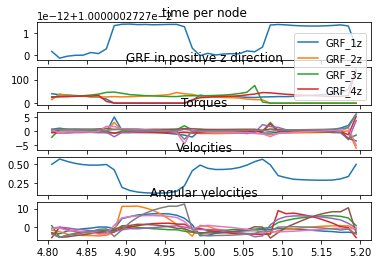

In [28]:
print(results.solver.status) 
print(results.solver.termination_condition) 

# Plotting the stuff --------------------------------------------------
fig, axs = plt.subplots(5)


print(f"theta x: {m.q0[1,'theta_bx'].value}")
print(f"theta y: {m.q0[1,'theta_by'].value}")
print(f"theta z: {m.q0[1,'theta_bz'].value}")


# Time stuff ----------------------------------------------------------
duration=m.tt0[N].value-m.tt0[1].value
print(f"tt0[1]: {m.tt0[1].value}")
print(f"tt0[N]: {m.tt0[N].value}")
print(f"duration: {duration}s")
print(f"final distance covered: {m.q0[N,'x'].value}s")
print(f"average velocity: {m.q0[N,'x'].value/duration}")
print(f"hm: {hm}s") 

time = np.zeros(N)
tt0 = np.zeros(N)
sum_z_vel = 0
min_z_vel = 100
max_z_vel = 0

for i in range(1,N+1):
    time[i-1]=m.h[i].value
    tt0[i-1]=m.tt0[i].value
    sum_z_vel=sum_z_vel+m.dq0[i,'x'].value
    print(f"node {i} duration: {m.h[i].value}")
    if m.dq0[i,'x'].value < min_z_vel:
        min_z_vel=m.dq0[i,'x'].value
    if m.dq0[i,'x'].value > max_z_vel:
        max_z_vel=m.dq0[i,'x'].value

avg_z_vel=sum_z_vel/N
print(f"average z velocity: {avg_z_vel}")
print(f"minimum z velocity: {min_z_vel}")
print(f"maximum z velocity: {max_z_vel}")
    
axs[0].plot(tt0, time)
axs[0].set_title("time per node")

# GRF z ps -------------------------------------------------------------
GRF_1z = np.zeros(N) 
GRF_2z = np.zeros(N) 
GRF_3z = np.zeros(N) 
GRF_4z = np.zeros(N) 
for i in range(1,N+1):
    GRF_1z[i-1]=m.GRF1[i,3,'Z','ps'].value
    GRF_2z[i-1]=m.GRF2[i,3,'Z','ps'].value
    GRF_3z[i-1]=m.GRF3[i,3,'Z','ps'].value
    GRF_4z[i-1]=m.GRF4[i,3,'Z','ps'].value
    
axs[1].plot(tt0, GRF_1z)
axs[1].plot(tt0, GRF_2z)
axs[1].plot(tt0, GRF_3z)
axs[1].plot(tt0, GRF_4z)
axs[1].set_title("GRF in positive z direction")
axs[1].legend(["GRF_1z", "GRF_2z","GRF_3z", "GRF_4z"])

# Torques --------------------------------------------------------------
tau_h1 = np.zeros(N) 
tau_k1 = np.zeros(N) 
tau_h2 = np.zeros(N) 
tau_k2 = np.zeros(N) 
tau_h3 = np.zeros(N) 
tau_k3 = np.zeros(N) 
tau_h4 = np.zeros(N) 
tau_k4 = np.zeros(N)
for i in range(1,N+1):
    tau_h1[i-1]=m.tau_h1[i].value
    tau_k1[i-1]=m.tau_k1[i].value
    tau_h2[i-1]=m.tau_h2[i].value
    tau_k2[i-1]=m.tau_k2[i].value
    tau_h3[i-1]=m.tau_h3[i].value
    tau_k3[i-1]=m.tau_k3[i].value
    tau_h4[i-1]=m.tau_h4[i].value
    tau_k4[i-1]=m.tau_k4[i].value
    
axs[2].plot(tt0, tau_h1)
axs[2].plot(tt0, tau_k1)
axs[2].plot(tt0, tau_h2)
axs[2].plot(tt0, tau_k2)
axs[2].plot(tt0, tau_h3)
axs[2].plot(tt0, tau_k3)
axs[2].plot(tt0, tau_h4)
axs[2].plot(tt0, tau_k4)
axs[2].set_title("Torques")
# axs[2].legend(["tau_h1", "tau_k1","tau_h2", "tau_k2","tau_h3", "tau_k3","tau_h4", "tau_k4"],loc='upper right')

# Velocities --------------------------------------------------------------
v_x = np.zeros(N) 

for i in range(1,N+1):
    v_x[i-1]=m.dq0[i,'x'].value
    
axs[3].plot(tt0, v_x)
axs[3].set_title("Velocities")

# Angular Velocity --------------------------------------------------------------
w_h1 = np.zeros(N) 
w_k1 = np.zeros(N) 
w_h2 = np.zeros(N) 
w_k2 = np.zeros(N) 
w_h3 = np.zeros(N) 
w_k3 = np.zeros(N) 
w_h4 = np.zeros(N) 
w_k4 = np.zeros(N)
for i in range(1,N+1):
    w_h1[i-1]=m.dq0[i,'theta_h1'].value
    w_k1[i-1]=m.dq0[i,'theta_k1'].value
    w_h2[i-1]=m.dq0[i,'theta_h2'].value
    w_k2[i-1]=m.dq0[i,'theta_k2'].value
    w_h3[i-1]=m.dq0[i,'theta_h3'].value
    w_k3[i-1]=m.dq0[i,'theta_k3'].value
    w_h4[i-1]=m.dq0[i,'theta_h4'].value
    w_k4[i-1]=m.dq0[i,'theta_k4'].value
    
axs[4].plot(tt0, w_h1)
axs[4].plot(tt0, w_k1)
axs[4].plot(tt0, w_h2)
axs[4].plot(tt0, w_k2)
axs[4].plot(tt0, w_h3)
axs[4].plot(tt0, w_k3)
axs[4].plot(tt0, w_h4)
axs[4].plot(tt0, w_k4)
axs[4].set_title("Angular velocities")
# axs[4].legend(["h1", "k1","h2", "k2","h3", "k3","h4", "k4"],loc='upper right')


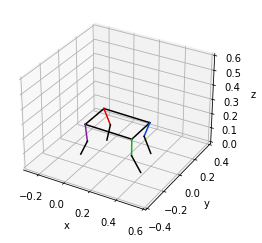

In [29]:
# Animation stuff -------------------------------------------------------
#-----------Print 3D---------------------
fig1 = plt.figure()
ax1 = plt.axes(projection='3d') #create axes

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-0.3, 0.6) 
    ax.set_ylim(-0.4, 0.4)
    ax.set_zlim(-0.0, 0.6);

    rx=[[1, 0, 0], [0, cos(m.q0[i,'theta_bx'].value), -sin(m.q0[i,'theta_bx'].value)], [0, sin(m.q0[i,'theta_bx'].value), cos(m.q0[i,'theta_bx'].value)]]
    ry=[[cos(m.q0[i,'theta_by'].value), 0, sin(m.q0[i,'theta_by'].value)], [0, 1, 0], [-sin(m.q0[i,'theta_by'].value), 0, cos(m.q0[i,'theta_by'].value)]]
    rz=[[cos(m.q0[i,'theta_bz'].value), -sin(m.q0[i,'theta_bz'].value), 0], [sin(m.q0[i,'theta_bz'].value), cos(m.q0[i,'theta_bz'].value), 0], [0, 0, 1]]
    rxy=np.matmul(rx,ry)
    rxyz=np.matmul(rxy,rz)

    Hip11=[[0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip22=[[0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]
    Hip33=[[-0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip44=[[-0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]

    Knee11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)]]
    Knee22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)]]
    Knee33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)]]
    Knee44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)]]

    Foot11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k1'].value)]]
    Foot22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k2'].value)]]
    Foot33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k3'].value)]]
    Foot44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k4'].value)]]

    b = [[m.q0[i,'x'].value],[m.q0[i,'y'].value],[m.q0[i,'z'].value]]

    h1 = b + np.matmul(rxyz,Hip11)
    h2 = b + np.matmul(rxyz,Hip22)
    h3 = b + np.matmul(rxyz,Hip33)
    h4 = b + np.matmul(rxyz,Hip44)

    k1 = b + np.matmul(rxyz,Knee11)
    k2 = b + np.matmul(rxyz,Knee22)
    k3 = b + np.matmul(rxyz,Knee33)
    k4 = b + np.matmul(rxyz,Knee44)

    foot1= b + np.matmul(rxyz,Foot11)
    foot2= b + np.matmul(rxyz,Foot22)
    foot3= b + np.matmul(rxyz,Foot33)
    foot4= b + np.matmul(rxyz,Foot44)

    #plot body
    ax.plot([h1[0,0],h2[0,0]],[h1[1,0],h2[1,0]],[h1[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h1[0,0],h3[0,0]],[h1[1,0],h3[1,0]],[h1[2,0],h3[2,0]],color='xkcd:black')
    ax.plot([h4[0,0],h2[0,0]],[h4[1,0],h2[1,0]],[h4[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h3[0,0],h4[0,0]],[h3[1,0],h4[1,0]],[h3[2,0],h4[2,0]],color='xkcd:black')
    
    #Plot Femur 1
    ax.plot([h1[0,0],k1[0,0]],[h1[1,0],k1[1,0]],[h1[2,0],k1[2,0]],color='xkcd:blue')

    #Plot Femur 2
    ax.plot([h2[0,0],k2[0,0]],[h2[1,0],k2[1,0]],[h2[2,0],k2[2,0]],color='xkcd:green')

    #Plot Femur 3
    ax.plot([h3[0,0],k3[0,0]],[h3[1,0],k3[1,0]],[h3[2,0],k3[2,0]],color='xkcd:red')

    #Plot Femur 4
    ax.plot([h4[0,0],k4[0,0]],[h4[1,0],k4[1,0]],[h4[2,0],k4[2,0]],color='xkcd:purple')

    #Plot Tibia 1
    ax.plot([k1[0,0],foot1[0,0]],[k1[1,0],foot1[1,0]],[k1[2,0],foot1[2,0]],color='xkcd:black')

    #Plot Tibia 2
    ax.plot([k2[0,0],foot2[0,0]],[k2[1,0],foot2[1,0]],[k2[2,0],foot2[2,0]],color='xkcd:black')

    #Plot Tibia 3
    ax.plot([k3[0,0],foot3[0,0]],[k3[1,0],foot3[1,0]],[k3[2,0],foot3[2,0]],color='xkcd:black')

    #Plot Tibia 4
    ax.plot([k4[0,0],foot4[0,0]],[k4[1,0],foot4[1,0]],[k4[2,0],foot4[2,0]],color='xkcd:black')
       
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = m.h[i-1].value*hm*10000,repeat=False)
# m.h[i].value*hm*100000
# animate.save('3D_Quad.gif', writer='PillowWriter', fps=10)

HTML(animate.to_jshtml())

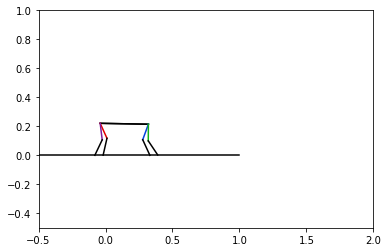

In [30]:
# Animation stuff -------------------------------------------------------
#-----------Print 2D - X-Z ---------------------
fig2,ax2= plt.subplots(1,1) #create axes

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,2])
    ax.set_ylim([-0.5,1.0])
    
    rx=[[1, 0, 0], [0, cos(m.q0[i,'theta_bx'].value), -sin(m.q0[i,'theta_bx'].value)], [0, sin(m.q0[i,'theta_bx'].value), cos(m.q0[i,'theta_bx'].value)]]
    ry=[[cos(m.q0[i,'theta_by'].value), 0, sin(m.q0[i,'theta_by'].value)], [0, 1, 0], [-sin(m.q0[i,'theta_by'].value), 0, cos(m.q0[i,'theta_by'].value)]]
    rz=[[cos(m.q0[i,'theta_bz'].value), -sin(m.q0[i,'theta_bz'].value), 0], [sin(m.q0[i,'theta_bz'].value), cos(m.q0[i,'theta_bz'].value), 0], [0, 0, 1]]
    rxy=np.matmul(rx,ry)
    rxyz=np.matmul(rxy,rz)

    Hip11=[[0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip22=[[0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]
    Hip33=[[-0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip44=[[-0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]

    Knee11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)]]
    Knee22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)]]
    Knee33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)]]
    Knee44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)]]

    Foot11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k1'].value)]]
    Foot22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k2'].value)]]
    Foot33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k3'].value)]]
    Foot44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k4'].value)]]

    b = [[m.q0[i,'x'].value],[m.q0[i,'y'].value],[m.q0[i,'z'].value]]

    h1 = b + np.matmul(rxyz,Hip11)
    h2 = b + np.matmul(rxyz,Hip22)
    h3 = b + np.matmul(rxyz,Hip33)
    h4 = b + np.matmul(rxyz,Hip44)

    k1 = b + np.matmul(rxyz,Knee11)
    k2 = b + np.matmul(rxyz,Knee22)
    k3 = b + np.matmul(rxyz,Knee33)
    k4 = b + np.matmul(rxyz,Knee44)

    foot1= b + np.matmul(rxyz,Foot11)
    foot2= b + np.matmul(rxyz,Foot22)
    foot3= b + np.matmul(rxyz,Foot33)
    foot4= b + np.matmul(rxyz,Foot44)
    
   #plot body
    ax.plot([h1[0,0],h2[0,0]],[h1[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h1[0,0],h3[0,0]],[h1[2,0],h3[2,0]],color='xkcd:black')
    ax.plot([h4[0,0],h2[0,0]],[h4[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h3[0,0],h4[0,0]],[h3[2,0],h4[2,0]],color='xkcd:black')
    
    #Plot Femur 1
    ax.plot([h1[0,0],k1[0,0]],[h1[2,0],k1[2,0]],color='xkcd:blue')

    #Plot Femur 2
    ax.plot([h2[0,0],k2[0,0]],[h2[2,0],k2[2,0]],color='xkcd:green')

    #Plot Femur 3
    ax.plot([h3[0,0],k3[0,0]],[h3[2,0],k3[2,0]],color='xkcd:red')

    #Plot Femur 4
    ax.plot([h4[0,0],k4[0,0]],[h4[2,0],k4[2,0]],color='xkcd:purple')

    #Plot Tibia 1
    ax.plot([k1[0,0],foot1[0,0]],[k1[2,0],foot1[2,0]],color='xkcd:black')

    #Plot Tibia 2
    ax.plot([k2[0,0],foot2[0,0]],[k2[2,0],foot2[2,0]],color='xkcd:black')

    #Plot Tibia 3
    ax.plot([k3[0,0],foot3[0,0]],[k3[2,0],foot3[2,0]],color='xkcd:black')

    #Plot Tibia 4
    ax.plot([k4[0,0],foot4[0,0]],[k4[2,0],foot4[2,0]],color='xkcd:black')
    
#     Ground
    ax.plot([-0.5,1.0],[0,0],color='xkcd:black')
       
update = lambda i: plot_robot(i,m,ax2) #lambdify update function

animate = ani.FuncAnimation(fig2,update,range(1,N+1),interval = m.h[i].value*hm*10000,repeat=False)
# m.h[i].value*hm*100000
# animate.save('XZ_Quad_5.gif', writer='PillowWriter', fps=10)

HTML(animate.to_jshtml())

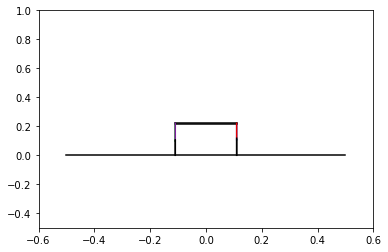

In [31]:
# Animation stuff -------------------------------------------------------
#-----------Print 2D - Y-Z ---------------------
fig3,ax3= plt.subplots(1,1) #create axes

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.6,0.6])
    ax.set_ylim([-0.5,1.0])
    
    rx=[[1, 0, 0], [0, cos(m.q0[i,'theta_bx'].value), -sin(m.q0[i,'theta_bx'].value)], [0, sin(m.q0[i,'theta_bx'].value), cos(m.q0[i,'theta_bx'].value)]]
    ry=[[cos(m.q0[i,'theta_by'].value), 0, sin(m.q0[i,'theta_by'].value)], [0, 1, 0], [-sin(m.q0[i,'theta_by'].value), 0, cos(m.q0[i,'theta_by'].value)]]
    rz=[[cos(m.q0[i,'theta_bz'].value), -sin(m.q0[i,'theta_bz'].value), 0], [sin(m.q0[i,'theta_bz'].value), cos(m.q0[i,'theta_bz'].value), 0], [0, 0, 1]]
    rxy=np.matmul(rx,ry)
    rxyz=np.matmul(rxy,rz)

    Hip11=[[0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip22=[[0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]
    Hip33=[[-0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip44=[[-0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]

    Knee11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)]]
    Knee22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)]]
    Knee33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)]]
    Knee44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)]]

    Foot11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k1'].value)]]
    Foot22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k2'].value)]]
    Foot33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k3'].value)]]
    Foot44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k4'].value)]]

    b = [[m.q0[i,'x'].value],[m.q0[i,'y'].value],[m.q0[i,'z'].value]]

    h1 = b + np.matmul(rxyz,Hip11)
    h2 = b + np.matmul(rxyz,Hip22)
    h3 = b + np.matmul(rxyz,Hip33)
    h4 = b + np.matmul(rxyz,Hip44)

    k1 = b + np.matmul(rxyz,Knee11)
    k2 = b + np.matmul(rxyz,Knee22)
    k3 = b + np.matmul(rxyz,Knee33)
    k4 = b + np.matmul(rxyz,Knee44)

    foot1= b + np.matmul(rxyz,Foot11)
    foot2= b + np.matmul(rxyz,Foot22)
    foot3= b + np.matmul(rxyz,Foot33)
    foot4= b + np.matmul(rxyz,Foot44)
    
    #plot body
    ax.plot([h1[1,0],h2[1,0]],[h1[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h1[1,0],h3[1,0]],[h1[2,0],h3[2,0]],color='xkcd:black')
    ax.plot([h4[1,0],h2[1,0]],[h4[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h3[1,0],h4[1,0]],[h3[2,0],h4[2,0]],color='xkcd:black')
    
    #Plot Femur 1
    ax.plot([h1[1,0],k1[1,0]],[h1[2,0],k1[2,0]],color='xkcd:blue')

    #Plot Femur 2
    ax.plot([h2[1,0],k2[1,0]],[h2[2,0],k2[2,0]],color='xkcd:green')

    #Plot Femur 3
    ax.plot([h3[1,0],k3[1,0]],[h3[2,0],k3[2,0]],color='xkcd:red')

    #Plot Femur 4
    ax.plot([h4[1,0],k4[1,0]],[h4[2,0],k4[2,0]],color='xkcd:purple')

    #Plot Tibia 1
    ax.plot([k1[1,0],foot1[1,0]],[k1[2,0],foot1[2,0]],color='xkcd:black')

    #Plot Tibia 2
    ax.plot([k2[1,0],foot2[1,0]],[k2[2,0],foot2[2,0]],color='xkcd:black')

    #Plot Tibia 3
    ax.plot([k3[1,0],foot3[1,0]],[k3[2,0],foot3[2,0]],color='xkcd:black')

    #Plot Tibia 4
    ax.plot([k4[1,0],foot4[1,0]],[k4[2,0],foot4[2,0]],color='xkcd:black')
    
#     Ground
    ax.plot([-0.5,0.5],[0,0],color='xkcd:black')
       
update = lambda i: plot_robot(i,m,ax3) #lambdify update function

animate = ani.FuncAnimation(fig3,update,range(1,N+1),interval = m.h[i].value*hm*1000,repeat=False)
# m.h[i].value*hm*100000
# animate.save('YZ_Quad_without_Y_slip.gif', writer='PillowWriter', fps=10)

HTML(animate.to_jshtml())

In [32]:
# #SAVING PARAMETERS
# import pandas as pd
# #Physical properties -----------------------------------------------------------------------------------------------
# properties = {'N':[N],'Body Mass':[m.m[('body',1)]],'Femur 1 Mass':[m.m[('femur',1)]],'Tibia 1 Mass':[m.m[('tibia',1)]],'Femur 2 Mass':[m.m[('femur',2)]],
#                                     'Tibia 2 Mass':[m.m[('tibia',2)]],'Femur 3 Mass':[m.m[('femur',3)]],'Tibia 3 Mass':[m.m[('tibia',3)]],'Femur 4 Mass':[m.m[('femur',4)]],'Tibia 4 Mass':[m.m[('tibia',4)]],
#                                     'Body Length':[m.l[('body',1)]],'Body Width':[m.l[('bodyWidth',1)]],'Femur 1 Length':[m.l[('femur',1)]],'Tibia 1 Length':[m.l[('tibia',1)]],'Femur 2 Length':[m.l[('femur',2)]],'Tibia 2 Length':[m.l[('tibia',2)]],
#                                     'Femur 3 Length':[m.l[('femur',3)]],'Tibia 3 Length':[m.l[('tibia',3)]],'Femur 4 Length':[m.l[('femur',4)]],'Tibia 4 Length':[m.l[('tibia',4)]]}
# Properties = pd.DataFrame(properties)
# Properties.to_csv (r'C:\Users\Marethe\Documents\Masters_2.0\Quad_simulations\3D\3D_Properties.csv', index = False, header=True)

# #Torques, node time steps ------------------------------------------------------------------------------------------------------------
# torques = {'Node timesteps':[m.h[n].value for n in range (1, N+1)],'Torque Hip 1':[m.tau_h1[n].value for n in range (1, N+1)],'Torque Knee 1':[m.tau_k1[n].value for n in range (1, N+1)],'Torque Hip 2':[m.tau_h2[n].value for n in range (1, N+1)],'Torque Knee 2':[m.tau_k2[n].value for n in range (1, N+1)],
#                                     'Torque Hip 3':[m.tau_h3[n].value for n in range (1, N+1)],'Torque Knee 3':[m.tau_k3[n].value for n in range (1, N+1)],'Torque Hip 4':[m.tau_h4[n].value for n in range (1, N+1)],'Torque Knee 4':[m.tau_k4[n].value for n in range (1, N+1)]}
# Torques = pd.DataFrame(torques)
# Torques.to_csv (r'C:\Users\Marethe\Documents\Masters_2.0\Quad_simulations\3D\3D_Nodal.csv', index = False, header=True)

# #Trajectories per collocation point - Angles, Velocities and GRFs - unaltered ----------------------------------------------------------------------------------------
# qx = [0 for x in range(N*3)]
# qy = [0 for x in range(N*3)]
# qz = [0 for x in range(N*3)]
# qthx = [0 for x in range(N*3)]
# qthy = [0 for x in range(N*3)]
# qthz = [0 for x in range(N*3)]
# qh1 = [0 for x in range(N*3)]
# qk1 = [0 for x in range(N*3)]
# qh2 = [0 for x in range(N*3)]
# qk2 = [0 for x in range(N*3)]
# qh3 = [0 for x in range(N*3)]
# qk3 = [0 for x in range(N*3)]
# qh4 = [0 for x in range(N*3)]
# qk4 = [0 for x in range(N*3)]

# dqx = [0 for x in range(N*3)]
# dqy = [0 for x in range(N*3)]
# dqz = [0 for x in range(N*3)]
# dqthx = [0 for x in range(N*3)]
# dqthy = [0 for x in range(N*3)]
# dqthz = [0 for x in range(N*3)]
# dqh1 = [0 for x in range(N*3)]
# dqk1 = [0 for x in range(N*3)]
# dqh2 = [0 for x in range(N*3)]
# dqk2 = [0 for x in range(N*3)]
# dqh3 = [0 for x in range(N*3)]
# dqk3 = [0 for x in range(N*3)]
# dqh4 = [0 for x in range(N*3)]
# dqk4 = [0 for x in range(N*3)]

# grf1x = [0 for x in range(N*3)]
# grf1y = [0 for x in range(N*3)]
# grf1z = [0 for x in range(N*3)]
# grf2x = [0 for x in range(N*3)]
# grf2y = [0 for x in range(N*3)]
# grf2z = [0 for x in range(N*3)]
# grf3x = [0 for x in range(N*3)]
# grf3y = [0 for x in range(N*3)]
# grf3z = [0 for x in range(N*3)]
# grf4x = [0 for x in range(N*3)]
# grf4y = [0 for x in range(N*3)]
# grf4z = [0 for x in range(N*3)]

# for n in range (1,N+1):
#     for c in range (0,3):
#         i = n*3-3+c
#         qx[i] = m.q[n,c+1,'x'].value
#         qy[i] = m.q[n,c+1,'x'].value
#         qz[i] = m.q[n,c+1,'z'].value
#         qthx[i] = m.q[n,c+1,'theta_bx'].value
#         qthy[i] = m.q[n,c+1,'theta_by'].value
#         qthz[i] = m.q[n,c+1,'theta_bz'].value
#         qh1[i] = m.q[n,c+1,'theta_h1'].value
#         qk1[i] = m.q[n,c+1,'theta_k1'].value
#         qh2[i] = m.q[n,c+1,'theta_h2'].value
#         qk2[i] = m.q[n,c+1,'theta_k2'].value
#         qh3[i] = m.q[n,c+1,'theta_h3'].value
#         qk3[i] = m.q[n,c+1,'theta_k3'].value
#         qh4[i] = m.q[n,c+1,'theta_h4'].value
#         qk4[i] = m.q[n,c+1,'theta_k4'].value
        
#         dqx[i] = m.dq[n,c+1,'x'].value
#         dqy[i] = m.dq[n,c+1,'x'].value
#         dqz[i] = m.dq[n,c+1,'z'].value
#         dqthx[i] = m.dq[n,c+1,'theta_bx'].value
#         dqthy[i] = m.dq[n,c+1,'theta_by'].value
#         dqthz[i] = m.dq[n,c+1,'theta_bz'].value
#         dqh1[i] = m.dq[n,c+1,'theta_h1'].value
#         dqk1[i] = m.dq[n,c+1,'theta_k1'].value
#         dqh2[i] = m.dq[n,c+1,'theta_h2'].value
#         dqk2[i] = m.dq[n,c+1,'theta_k2'].value
#         dqh3[i] = m.dq[n,c+1,'theta_h3'].value
#         dqk3[i] = m.dq[n,c+1,'theta_k3'].value
#         dqh4[i] = m.dq[n,c+1,'theta_h4'].value
#         dqk4[i] = m.dq[n,c+1,'theta_k4'].value
        
#         grf1x[i] = m.GRF1[n,c+1,'X','ps'].value-m.GRF1[n,c+1,'X','ng'].value
#         grf1y[i] = m.GRF1[n,c+1,'Y','ps'].value-m.GRF1[n,c+1,'Y','ng'].value
#         grf1z[i] = m.GRF1[n,c+1,'Z','ps'].value
#         grf2x[i] = m.GRF2[n,c+1,'X','ps'].value-m.GRF2[n,c+1,'X','ng'].value
#         grf2y[i] = m.GRF2[n,c+1,'Y','ps'].value-m.GRF2[n,c+1,'Y','ng'].value
#         grf2z[i] = m.GRF2[n,c+1,'Z','ps'].value
#         grf3x[i] = m.GRF3[n,c+1,'X','ps'].value-m.GRF3[n,c+1,'X','ng'].value
#         grf3y[i] = m.GRF3[n,c+1,'Y','ps'].value-m.GRF3[n,c+1,'Y','ng'].value
#         grf3z[i] = m.GRF3[n,c+1,'Z','ps'].value
#         grf4x[i] = m.GRF4[n,c+1,'X','ps'].value-m.GRF4[n,c+1,'X','ng'].value
#         grf4y[i] = m.GRF4[n,c+1,'Y','ps'].value-m.GRF4[n,c+1,'Y','ng'].value
#         grf4z[i] = m.GRF4[n,c+1,'Z','ps'].value

# movement_traj = {'X Position':[qx[i] for i in range (len(qx))],'Y Position':[qy[i] for i in range (len(qy))],'Z Position':[qz[i] for i in range (len(qz))],'Body Angle x':[qthx[i] for i in range (len(qthx))],'Body Angle y':[qthy[i] for i in range (len(qthy))],'Body Angle z':[qthz[i] for i in range (len(qthz))],'Hip 1 Angle':[qh1[i] for i in range (len(qh1))],'Knee 1 Angle':[qk1[i] for i in range (len(qk1))],'Hip 2 Angle':[qh2[i] for i in range (len(qh2))],'Knee 2 Angle':[qk2[i] for i in range (len(qk2))],
#            'Hip 3 Angle':[qh3[i] for i in range (len(qh3))],'Knee 3 Angle':[qk3[i] for i in range (len(qk3))],'Hip 4 Angle':[qh4[i] for i in range (len(qh4))],'Knee 4 Angle':[qk4[i] for i in range (len(qk4))],
#            'X Velocity':[dqx[i] for i in range (len(dqx))],'Z Velocity':[dqz[i] for i in range (len(dqz))],'Body Velocity x':[dqthx[i] for i in range (len(dqthx))],'Body Velocity y':[dqthy[i] for i in range (len(dqthy))],'Body Velocity z':[dqthz[i] for i in range (len(dqthz))],'Hip 1 Velocity':[dqh1[i] for i in range (len(dqh1))],'Knee 1 Velocity':[dqk1[i] for i in range (len(dqk1))],'Hip 2 Velocity':[dqh2[i] for i in range (len(dqh2))],'Knee 2 Velocity':[dqk2[i] for i in range (len(dqk2))],
#            'Hip 3 Velocity':[dqh3[i] for i in range (len(dqh3))],'Knee 3 Velocity':[dqk3[i] for i in range (len(dqk3))],'Hip 4 Velocity':[dqh4[i] for i in range (len(dqh4))],'Knee 4 Velocity':[dqk4[i] for i in range (len(dqk4))],
#            'GRF 1x':[grf1x[i] for i in range (len(grf1x))],'GRF 2x':[grf2x[i] for i in range (len(grf2x))],'GRF 3x':[grf3x[i] for i in range (len(grf3x))],'GRF 4x':[grf4x[i] for i in range (len(grf4x))],
#            'GRF 1y':[grf1y[i] for i in range (len(grf1y))],'GRF 2y':[grf2y[i] for i in range (len(grf2y))],'GRF 3y':[grf3y[i] for i in range (len(grf3y))],'GRF 4y':[grf4y[i] for i in range (len(grf4y))],
#            'GRF 1z':[grf1z[i] for i in range (len(grf1z))],'GRF 2z':[grf2z[i] for i in range (len(grf2z))],'GRF 3z':[grf3z[i] for i in range (len(grf3z))],'GRF 4z':[grf4z[i] for i in range (len(grf4z))]}

# Movement_traj = pd.DataFrame(movement_traj)
# Movement_traj.to_csv (r'C:\Users\Marethe\Documents\Masters_2.0\Quad_simulations\3D\3D_col_traj.csv', index = False, header=True)

# #ROS trajectories per collocation point  - Angles, Velocities and GRFs - altered ----------------------------------------------------------------------------------------
# r_qx = [0 for x in range(N*3)]
# r_qy = [0 for x in range(N*3)]
# r_qz = [0 for x in range(N*3)]
# r_qthx = [0 for x in range(N*3)]
# r_qthy = [0 for x in range(N*3)]
# r_qthz = [0 for x in range(N*3)]
# r_qh1 = [0 for x in range(N*3)]
# r_qk1 = [0 for x in range(N*3)]
# r_qh2 = [0 for x in range(N*3)]
# r_qk2 = [0 for x in range(N*3)]
# r_qh3 = [0 for x in range(N*3)]
# r_qk3 = [0 for x in range(N*3)]
# r_qh4 = [0 for x in range(N*3)]
# r_qk4 = [0 for x in range(N*3)]
# t = [0 for x in range(N*3)]
# t_new = [0 for x in range(N*3)]


# for n in range (1,N+1):
#     for c in range (0,3):
#         i = n*3-3+c
#         r_qx[i] = m.q[n,c+1,'x'].value
#         r_qy[i] = m.q[n,c+1,'y'].value
#         r_qz[i] = m.q[n,c+1,'z'].value
#         r_qthx[i] = m.q[n,c+1,'theta_bx'].value
#         r_qthy[i] = m.q[n,c+1,'theta_by'].value
#         r_qthz[i] = m.q[n,c+1,'theta_bz'].value
#         r_qh1[i] = m.q[n,c+1,'theta_h1'].value
#         r_qk1[i] = m.q[n,c+1,'theta_k1'].value
#         r_qh2[i] = m.q[n,c+1,'theta_h2'].value
#         r_qk2[i] = m.q[n,c+1,'theta_k2'].value
#         r_qh3[i] = m.q[n,c+1,'theta_h3'].value
#         r_qk3[i] = m.q[n,c+1,'theta_k3'].value
#         r_qh4[i] = m.q[n,c+1,'theta_h4'].value
#         r_qk4[i] = m.q[n,c+1,'theta_k4'].value
#         t[i] = m.tt[n,c+1].value
 
# for n in range (1,len(t)):
#     t_new[n]=t[n]-t[n-1]
# t_new[0]=m.h[1].value/3

# movement_ros = {'X Position':[r_qx[i] for i in range (len(r_qx))],'Y Position':[r_qy[i] for i in range (len(r_qy))],'Z Position':[r_qz[i] for i in range (len(r_qz))],'Body Angle x':[r_qthx[i] for i in range (len(r_qthx))],'Body Angle y':[r_qthy[i] for i in range (len(r_qthy))],'Body Angle z':[r_qthz[i] for i in range (len(r_qthz))],'Hip 1 Angle':[r_qh1[i] for i in range (len(r_qh1))],'Knee 1 Angle':[r_qk1[i] for i in range (len(r_qk1))],'Hip 2 Angle':[r_qh2[i] for i in range (len(r_qh2))],'Knee 2 Angle':[r_qk2[i] for i in range (len(r_qk2))],
#            'Hip 3 Angle':[r_qh3[i] for i in range (len(r_qh3))],'Knee 3 Angle':[r_qk3[i] for i in range (len(r_qk3))],'Hip 4 Angle':[r_qh4[i] for i in range (len(r_qh4))],'Knee 4 Angle':[r_qk4[i] for i in range (len(r_qk4))],'m.tt':[t_new[i] for i in range (len(t))]}

# Movement_ros = pd.DataFrame(movement_ros)
# Movement_ros.to_csv (r'C:\Users\Marethe\Documents\Masters_2.0\Quad_simulations\3D\3D_col_ros.csv', index = False, header=True)


# print('Done')